In [ ]:
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow import keras
import matplotlib.pyplot as plt
from PIL import Image, ImageFilter
import numpy as np
from PIL import Image
import cv2
import matplotlib.image as mpimg
import os
import scipy.ndimage as ndimage
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score

In [ ]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS = 3
EPOCHS = 30

In [ ]:
#importing dataset
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/LeafDiseaseDetection/images",
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2273 files belonging to 10 classes.


In [ ]:
#display dataset classes
class_names = dataset.class_names
class_names

['guava_diseased',
 'guava_healthy',
 'jamun_diseased',
 'jamun_healthy',
 'lemon_diseased',
 'lemon_healthy',
 'mango_diseased',
 'mango_healthy',
 'pomegranate_diseased',
 'pomegrenate_healthy']

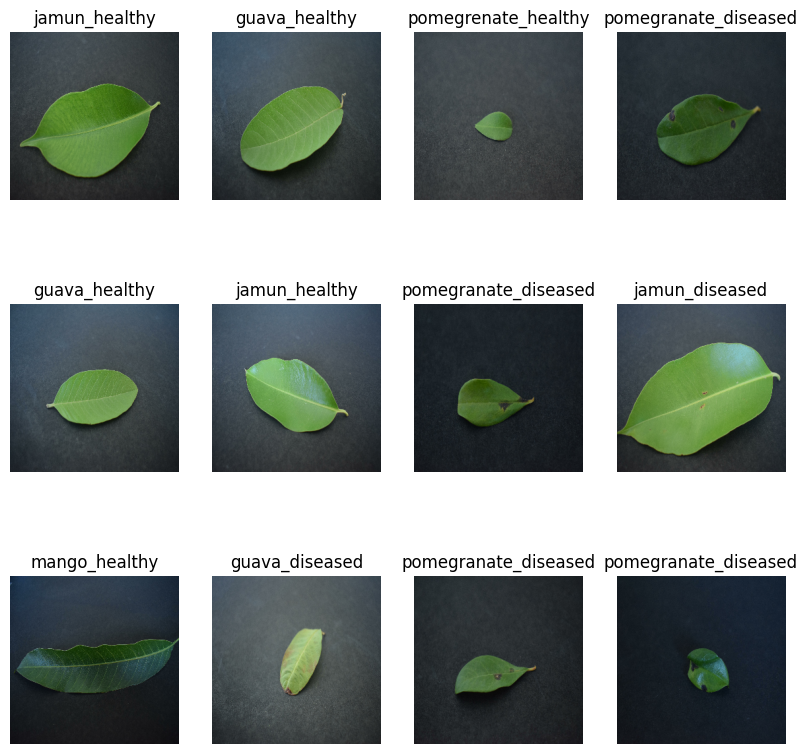

In [ ]:
# Display Images

plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [ ]:
len(dataset)

72

In [ ]:
#train dataset length calculation
train_size = 0.8
len(dataset)*train_size

57.6

In [ ]:
train_ds = dataset.take(57)
len(train_ds)

57

In [ ]:
#test dataset lenght calculation
test_ds = dataset.skip(57)
len(test_ds)

15

In [ ]:
#validation dataset length calculation
val_size=0.1
len(dataset)*val_size

7.2

In [ ]:
val_ds = test_ds.take(7)
len(val_ds)

7

In [ ]:
test_ds = test_ds.skip(7)
len(test_ds)

8

In [ ]:
#dataset partition

def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [ ]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [ ]:
len(dataset)

72

In [ ]:
len(train_ds)

57

In [ ]:
len(val_ds)

7

In [ ]:
len(test_ds)

8

In [ ]:
train_ds = train_ds.cache().shuffle(10000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(10000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(10000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
#pre-processing: image resizing and rescaling
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [ ]:
normalized_dataset = dataset.map(lambda x, y: (resize_and_rescale(x), y))

In [ ]:
for images, labels in normalized_dataset:
    for image in images:
        print(image)

tf.Tensor(
[[[0.14835326 0.17580424 0.20717679]
  [0.14884345 0.17629443 0.20766698]
  [0.15185356 0.17930454 0.20283397]
  ...
  [0.1728018  0.20809591 0.24339002]
  [0.1767157  0.21200982 0.24730393]
  [0.15757507 0.19679075 0.23208489]]

 [[0.14816177 0.17561276 0.20698531]
  [0.13508733 0.1625383  0.18606772]
  [0.14080884 0.16825981 0.19178922]
  ...
  [0.16850491 0.20772061 0.24301472]
  [0.15837164 0.19366576 0.22895987]
  [0.15998009 0.19527422 0.23056833]]

 [[0.14548102 0.172932   0.20430455]
  [0.1389706  0.16642158 0.18995099]
  [0.13386184 0.16131282 0.18484223]
  ...
  [0.1769608  0.21617648 0.2514706 ]
  [0.17110142 0.20639554 0.24168965]
  [0.14191177 0.17720589 0.2125    ]]

 ...

 [[0.10330883 0.09546569 0.1072304 ]
  [0.11840533 0.1105622  0.1223269 ]
  [0.11605393 0.10821079 0.11213236]
  ...
  [0.09803922 0.09803922 0.10588236]
  [0.10980393 0.10980393 0.11764707]
  [0.10158549 0.10158549 0.10942862]]

 [[0.10880822 0.10096508 0.11272979]
  [0.1072304  0.09938726 0

tf.Tensor(
[[[0.19889706 0.23811276 0.27732846]
  [0.1964997  0.23571539 0.27493107]
  [0.20121785 0.24043353 0.27964923]
  ...
  [0.15992647 0.19914217 0.23835786]
  [0.17305455 0.21227023 0.2514859 ]
  [0.16958487 0.20880057 0.24409468]]

 [[0.19583334 0.23504904 0.27426472]
  [0.1885187  0.22773439 0.26695007]
  [0.18431373 0.22352943 0.2627451 ]
  ...
  [0.17539063 0.21460633 0.253822  ]
  [0.17990197 0.21911766 0.2544118 ]
  [0.16752452 0.20674022 0.24203433]]

 [[0.17953433 0.21875001 0.2579657 ]
  [0.18161766 0.22083335 0.26004905]
  [0.19052544 0.22974113 0.2689568 ]
  ...
  [0.18210785 0.22132355 0.26053923]
  [0.17340687 0.208701   0.24399512]
  [0.16250001 0.19387256 0.23700982]]

 ...

 [[0.1451057  0.14118414 0.16079198]
  [0.1483073  0.14438573 0.16399358]
  [0.14538144 0.16106772 0.17283243]
  ...
  [0.13660386 0.15229015 0.16405486]
  [0.13923867 0.15492494 0.16668965]
  [0.14692862 0.1626149  0.16653647]]

 [[0.16305915 0.15913758 0.17874542]
  [0.14534314 0.14142157 0

tf.Tensor(
[[[0.18066025 0.22771907 0.28262103]
  [0.19443169 0.24149051 0.29639247]
  [0.18306527 0.2301241  0.28502604]
  ...
  [0.17056526 0.20978096 0.24899665]
  [0.1661918  0.20540749 0.24462317]
  [0.1661535  0.20536919 0.2406633 ]]

 [[0.18933825 0.23639707 0.29129905]
  [0.21360296 0.26066178 0.31556374]
  [0.18017004 0.22722888 0.28213084]
  ...
  [0.16877298 0.20798868 0.24720436]
  [0.17123929 0.21045497 0.24967067]
  [0.15814187 0.19735755 0.23265167]]

 [[0.18688726 0.23394608 0.28884804]
  [0.17350644 0.22056527 0.27546725]
  [0.18239124 0.22945008 0.28435203]
  ...
  [0.17291668 0.21213236 0.25134805]
  [0.18183978 0.22105546 0.2563496 ]
  [0.16679688 0.19816944 0.24130669]]

 ...

 [[0.10196079 0.10196079 0.10980393]
  [0.11362593 0.11362593 0.12146907]
  [0.12320007 0.12320007 0.13104321]
  ...
  [0.11172642 0.11172642 0.11956955]
  [0.12205883 0.11813726 0.13774511]
  [0.10712317 0.1032016  0.12280944]]

 [[0.10612746 0.10612746 0.11397059]
  [0.11511949 0.11511949 0

tf.Tensor(
[[[0.18553923 0.20514707 0.21691178]
  [0.18077514 0.21214768 0.21999082]
  [0.19263941 0.21224725 0.22401196]
  ...
  [0.15881588 0.18626685 0.20979628]
  [0.165288   0.19273898 0.21626839]
  [0.16117495 0.18862593 0.21215534]]

 [[0.18823531 0.20784315 0.21960786]
  [0.1947687  0.21437654 0.22614124]
  [0.1769608  0.19656864 0.20833334]
  ...
  [0.16043966 0.18789063 0.21142004]
  [0.15183824 0.17928922 0.20281863]
  [0.16377911 0.1912301  0.21475951]]

 [[0.19093138 0.21053922 0.22230394]
  [0.183701   0.20330884 0.21507354]
  [0.19007353 0.20968139 0.2214461 ]
  ...
  [0.15910694 0.18655792 0.21008733]
  [0.14681374 0.17426471 0.19779412]
  [0.16728708 0.19865963 0.21042433]]

 ...

 [[0.1433747  0.1433747  0.15121783]
  [0.15281864 0.15281864 0.16066177]
  [0.16364124 0.16364124 0.17148438]
  ...
  [0.13982844 0.13982844 0.14767158]
  [0.13982844 0.15551472 0.16727942]
  [0.09571845 0.11140472 0.12316943]]

 [[0.14509805 0.14509805 0.15294118]
  [0.14926471 0.14926471 0

tf.Tensor(
[[[0.21566331 0.2666437  0.3293888 ]
  [0.20716147 0.25814188 0.32088697]
  [0.1814798  0.24422489 0.30304843]
  ...
  [0.17318475 0.21240044 0.25161612]
  [0.16346508 0.20268077 0.24189647]
  [0.14536612 0.18458182 0.2237975 ]]

 [[0.20185356 0.25283396 0.31557906]
  [0.20130976 0.25229016 0.31503525]
  [0.19581036 0.25855547 0.317379  ]
  ...
  [0.16875    0.2079657  0.24718139]
  [0.16626073 0.20547642 0.24469212]
  [0.13714768 0.17636336 0.21557906]]

 [[0.2134804  0.2644608  0.3272059 ]
  [0.208701   0.25968137 0.3224265 ]
  [0.20812654 0.25910693 0.32185203]
  ...
  [0.15837164 0.19758733 0.23680301]
  [0.15014553 0.18936123 0.22857691]
  [0.14681374 0.18602942 0.22524512]]

 ...

 [[0.11543352 0.11543352 0.12327666]
  [0.12928922 0.12928922 0.13713236]
  [0.11956955 0.11956955 0.12741269]
  ...
  [0.08998928 0.10567556 0.10959712]
  [0.09975491 0.11544118 0.11936275]
  [0.09633119 0.11201747 0.11593904]]

 [[0.11526502 0.11526502 0.12310816]
  [0.12475491 0.12475491 0

tf.Tensor(
[[[0.20242801 0.2651731  0.32791823]
  [0.1859758  0.24872091 0.311466  ]
  [0.20356159 0.2663067  0.3290518 ]
  ...
  [0.18039216 0.23529413 0.28627452]
  [0.16516545 0.21614584 0.27889094]
  [0.15994945 0.21092986 0.27367496]]

 [[0.20612746 0.26887256 0.33161765]
  [0.19509806 0.25784317 0.32058826]
  [0.19041821 0.2413986  0.30806527]
  ...
  [0.16558671 0.22048868 0.2714691 ]
  [0.18039216 0.23137257 0.29411766]
  [0.1832644  0.23032324 0.29306835]]

 [[0.19999236 0.25097275 0.31371784]
  [0.19769455 0.26043966 0.32318476]
  [0.1946921  0.24567251 0.3123392 ]
  ...
  [0.17839308 0.22937348 0.29211858]
  [0.18039216 0.227451   0.28235295]
  [0.18210785 0.22916669 0.29191178]]

 ...

 [[0.16777727 0.19522826 0.21875767]
  [0.15676318 0.18421416 0.20774359]
  [0.15229015 0.17974113 0.20327054]
  ...
  [0.12585784 0.12585784 0.13370098]
  [0.09975491 0.11544118 0.11936275]
  [0.10857078 0.12425705 0.12817863]]

 [[0.16188726 0.18933825 0.21286766]
  [0.16748622 0.1949372  0

tf.Tensor(
[[[0.16753983 0.24989279 0.3244026 ]
  [0.18443629 0.25502452 0.3334559 ]
  [0.17048101 0.25283396 0.32734376]
  ...
  [0.1527114  0.2154565  0.2782016 ]
  [0.14425552 0.20700063 0.26974574]
  [0.13210785 0.19485295 0.25759804]]

 [[0.16384804 0.246201   0.3207108 ]
  [0.16646753 0.24882048 0.32333028]
  [0.1803462  0.26269916 0.33720896]
  ...
  [0.1384804  0.2012255  0.2639706 ]
  [0.14587164 0.20861673 0.27136183]
  [0.1527497  0.21549481 0.2782399 ]]

 [[0.14976257 0.23211552 0.30662534]
  [0.16497397 0.24732691 0.31399357]
  [0.17426471 0.25661767 0.32328433]
  ...
  [0.14215687 0.20490198 0.2676471 ]
  [0.15026808 0.21301319 0.2757583 ]
  [0.14203432 0.20477943 0.26752454]]

 ...

 [[0.10637256 0.11813726 0.13774511]
  [0.09497549 0.1067402  0.12634805]
  [0.12140779 0.1331725  0.15278034]
  ...
  [0.08627451 0.10196079 0.1137255 ]
  [0.08149511 0.09718138 0.10894608]
  [0.10416667 0.1002451  0.11985295]]

 [[0.11342678 0.1251915  0.14479934]
  [0.09803922 0.10980393 0

tf.Tensor(
[[[0.1776961  0.22867648 0.2639706 ]
  [0.18903953 0.22433366 0.2831572 ]
  [0.19805455 0.24511337 0.30001533]
  ...
  [0.13604474 0.16349572 0.18702513]
  [0.15766698 0.18511796 0.20864737]
  [0.15720743 0.18465841 0.20818782]]

 [[0.18792127 0.2349801  0.28988206]
  [0.20469517 0.251754   0.30665597]
  [0.18396907 0.23102789 0.28592986]
  ...
  [0.1637255  0.19117649 0.2147059 ]
  [0.15412837 0.18157937 0.20510878]
  [0.15232845 0.17977943 0.20330884]]

 [[0.17953433 0.22659315 0.28149512]
  [0.1642157  0.21127452 0.2661765 ]
  [0.17981772 0.22687654 0.2817785 ]
  ...
  [0.15506281 0.1825138  0.20604321]
  [0.15428923 0.18174021 0.20526962]
  [0.15110295 0.17855394 0.20208335]]

 ...

 [[0.10857078 0.10072764 0.11249235]
  [0.11593138 0.10808824 0.11985295]
  [0.10931373 0.1014706  0.1132353 ]
  ...
  [0.1199755  0.1199755  0.12781863]
  [0.10796569 0.10796569 0.11580883]
  [0.11054688 0.11054688 0.11839002]]

 [[0.11004902 0.10220589 0.11397059]
  [0.12022059 0.11237746 0

tf.Tensor(
[[[0.12544425 0.14505209 0.1568168 ]
  [0.12928922 0.14889707 0.16066177]
  [0.11505822 0.13466606 0.14643078]
  ...
  [0.11066943 0.13027728 0.14204198]
  [0.10435816 0.12004443 0.13180913]
  [0.10529259 0.12097887 0.13274357]]

 [[0.11066177 0.13026962 0.14203432]
  [0.11413144 0.13373928 0.145504  ]
  [0.12228095 0.1418888  0.1536535 ]
  ...
  [0.10575981 0.12144609 0.12536766]
  [0.10837164 0.12405791 0.13582262]
  [0.09718138 0.11286765 0.12463236]]

 [[0.11066177 0.13026962 0.14203432]
  [0.11421569 0.13382354 0.14558825]
  [0.1254902  0.14509805 0.15686275]
  ...
  [0.09803922 0.1137255  0.11764707]
  [0.09524357 0.11092985 0.11485142]
  [0.10110295 0.11678922 0.12855393]]

 ...

 [[0.10453432 0.09669118 0.10845589]
  [0.11727942 0.10943628 0.11335785]
  [0.1137255  0.10588236 0.10980393]
  ...
  [0.07279412 0.06495099 0.06887256]
  [0.07585785 0.06801471 0.07193628]
  [0.07450981 0.06666667 0.07058824]]

 [[0.12132353 0.1134804  0.12524511]
  [0.10196079 0.09411766 0

tf.Tensor(
[[[0.2223499  0.27333027 0.30470285]
  [0.21299021 0.2522059  0.28750002]
  [0.21115197 0.25036767 0.2856618 ]
  ...
  [0.20000002 0.24313727 0.26666668]
  [0.21659775 0.259735   0.28326443]
  [0.19485295 0.23406865 0.26936275]]

 [[0.2126915  0.2636719  0.29504445]
  [0.21568629 0.25490198 0.2901961 ]
  [0.22794119 0.26715687 0.30245098]
  ...
  [0.21149664 0.2546339  0.2781633 ]
  [0.19199602 0.23513329 0.2586627 ]
  [0.18517157 0.22438727 0.25968137]]

 [[0.21704964 0.26803005 0.2994026 ]
  [0.21176472 0.2627451  0.29411766]
  [0.21507354 0.25428924 0.28958336]
  ...
  [0.20592067 0.24905792 0.27258733]
  [0.21865045 0.2617877  0.28531712]
  [0.18173255 0.22094823 0.25624236]]

 ...

 [[0.11629903 0.1319853  0.14375001]
  [0.13843444 0.13451287 0.15412071]
  [0.11564799 0.13133426 0.14309897]
  ...
  [0.1324755  0.14816177 0.15208334]
  [0.13225338 0.14793965 0.15186122]
  [0.13065258 0.14633885 0.15026042]]

 [[0.11397059 0.12965687 0.14142157]
  [0.11397059 0.12965687 0

tf.Tensor(
[[[0.17551318 0.21472888 0.250023  ]
  [0.15567556 0.20665595 0.24195008]
  [0.16852023 0.21950063 0.25479475]
  ...
  [0.18283549 0.2573453  0.32401198]
  [0.1852405  0.24406405 0.31857386]
  [0.1798024  0.2425475  0.3052926 ]]

 [[0.16715688 0.20637256 0.24166667]
  [0.18794425 0.22715995 0.26245406]
  [0.1800475  0.23102789 0.26240045]
  ...
  [0.20281863 0.27732846 0.34399512]
  [0.19338237 0.2522059  0.3267157 ]
  [0.16869639 0.2314415  0.2941866 ]]

 [[0.16862746 0.20784315 0.24313727]
  [0.18958335 0.24056374 0.2719363 ]
  [0.1764706  0.227451   0.2627451 ]
  ...
  [0.19178922 0.25061277 0.32512257]
  [0.1798024  0.23862593 0.31313574]
  [0.18077514 0.23959866 0.31410846]]

 ...

 [[0.11249235 0.11249235 0.12033548]
  [0.09659161 0.09659161 0.10443475]
  [0.09996171 0.09996171 0.10780485]
  ...
  [0.10980393 0.10588236 0.1254902 ]
  [0.08627451 0.08235294 0.10196079]
  [0.09889706 0.09497549 0.11458334]]

 [[0.09723499 0.09723499 0.10507813]
  [0.09926471 0.09926471 0

tf.Tensor(
[[[0.13612899 0.16357997 0.18710938]
  [0.13590688 0.16335785 0.18688726]
  [0.13224572 0.1596967  0.18322611]
  ...
  [0.14153646 0.16898745 0.19251686]
  [0.13704811 0.16449909 0.1880285 ]
  [0.12477789 0.16007201 0.17967986]]

 [[0.13805914 0.16551012 0.18903953]
  [0.1307981  0.1582491  0.1817785 ]
  [0.12303922 0.15049021 0.17401962]
  ...
  [0.13257506 0.16002606 0.18355547]
  [0.1511872  0.17863819 0.2021676 ]
  [0.1299173  0.15736827 0.18089768]]

 [[0.14509805 0.17254902 0.19607845]
  [0.14338236 0.17083335 0.19436276]
  [0.13496478 0.16241576 0.18594517]
  ...
  [0.12291668 0.15036766 0.17389707]
  [0.13639706 0.16384804 0.18737747]
  [0.13370864 0.16115963 0.18468904]]

 ...

 [[0.10894608 0.10110295 0.11286765]
  [0.11448377 0.10664063 0.11840533]
  [0.11936275 0.11151961 0.12328432]
  ...
  [0.10416667 0.10416667 0.11200981]
  [0.09938726 0.09938726 0.1072304 ]
  [0.09019608 0.09019608 0.09803922]]

 [[0.11060815 0.10276502 0.11452972]
  [0.11740196 0.10955883 0

tf.Tensor(
[[[0.17340687 0.24399512 0.3224265 ]
  [0.1647595  0.23534775 0.31377912]
  [0.15415901 0.22474726 0.30317864]
  ...
  [0.19044119 0.22965688 0.264951  ]
  [0.17512256 0.21433824 0.24963237]
  [0.18218444 0.22140014 0.25669426]]

 [[0.17426471 0.24485296 0.32328433]
  [0.1442402  0.21482845 0.29325983]
  [0.1606388  0.23122704 0.3096584 ]
  ...
  [0.1793122  0.2185279  0.253822  ]
  [0.18039216 0.21960786 0.25490198]
  [0.20299481 0.24221049 0.27750462]]

 [[0.1582108  0.22879903 0.3072304 ]
  [0.15906864 0.22965688 0.30808824]
  [0.16523439 0.23582262 0.31425402]
  ...
  [0.15514706 0.19436276 0.22965688]
  [0.18813573 0.22735143 0.2665671 ]
  [0.17523745 0.21445313 0.2536688 ]]

 ...

 [[0.10454198 0.09669884 0.10846355]
  [0.10953585 0.10169271 0.11345742]
  [0.11200981 0.10416667 0.11593138]
  ...
  [0.10588236 0.12156864 0.1254902 ]
  [0.11345742 0.1291437  0.13306527]
  [0.11544118 0.13112746 0.13504903]]

 [[0.11458334 0.1067402  0.11850491]
  [0.11499694 0.1071538  0

tf.Tensor(
[[[0.1843367  0.2235524  0.2627681 ]
  [0.16838236 0.20759805 0.24681374]
  [0.16972274 0.22070314 0.25599727]
  ...
  [0.16358763 0.20280331 0.24201901]
  [0.17339155 0.21260725 0.25182292]
  [0.16678922 0.20208335 0.26090688]]

 [[0.17279413 0.22377452 0.25906864]
  [0.1634421  0.2144225  0.24971662]
  [0.17218138 0.22316177 0.2584559 ]
  ...
  [0.15649511 0.1957108  0.23492648]
  [0.18472734 0.22394302 0.2631587 ]
  [0.15943629 0.1947304  0.25355393]]

 [[0.16776961 0.21875001 0.25404415]
  [0.1699755  0.20919119 0.24840687]
  [0.17312348 0.22410387 0.25939798]
  ...
  [0.156947   0.19224113 0.25106466]
  [0.17637102 0.21558672 0.2548024 ]
  [0.14069395 0.19167434 0.22696845]]

 ...

 [[0.13161765 0.13161765 0.13946079]
  [0.12534468 0.12534468 0.13318782]
  [0.12300093 0.12300093 0.13084407]
  ...
  [0.10829505 0.12398132 0.13574603]
  [0.07316177 0.08884805 0.09276962]
  [0.09411766 0.09411766 0.10196079]]

 [[0.10759804 0.10759804 0.11544118]
  [0.13308825 0.13308825 0

tf.Tensor(
[[[0.20931374 0.23676471 0.26029414]
  [0.20189187 0.22934285 0.25287226]
  [0.20048255 0.22793353 0.25146294]
  ...
  [0.17220436 0.1918122  0.21534161]
  [0.1787301  0.19833794 0.22186735]
  [0.16776961 0.18737747 0.21090688]]

 [[0.19693628 0.22438727 0.24791668]
  [0.2064951  0.23394608 0.2574755 ]
  [0.21247703 0.23992802 0.26345742]
  ...
  [0.16247703 0.18208487 0.20561428]
  [0.17523745 0.19484529 0.21053156]
  [0.18350951 0.20311736 0.21880363]]

 [[0.20172335 0.22917435 0.25270376]
  [0.22352943 0.2509804  0.27450982]
  [0.20428923 0.2317402  0.25526962]
  ...
  [0.1838695  0.20347734 0.21916361]
  [0.18308824 0.20269608 0.21838236]
  [0.17169118 0.19129904 0.20698531]]

 ...

 [[0.15685509 0.15685509 0.16469823]
  [0.1507353  0.1507353  0.15857844]
  [0.18133426 0.18133426 0.1891774 ]
  ...
  [0.14273132 0.14273132 0.15057446]
  [0.13053769 0.13053769 0.13838083]
  [0.12892158 0.12892158 0.13676472]]

 [[0.16899511 0.16899511 0.17683825]
  [0.14611673 0.14611673 0

tf.Tensor(
[[[0.15392157 0.1892157  0.21666668]
  [0.14509805 0.18039216 0.20784315]
  [0.14387256 0.17916667 0.20661765]
  ...
  [0.15307905 0.20013788 0.25503984]
  [0.15440412 0.20146294 0.2563649 ]
  [0.15215227 0.1992111  0.25411308]]

 [[0.12850031 0.16379443 0.19124542]
  [0.15661766 0.19191177 0.21936275]
  [0.13000154 0.16529566 0.19274664]
  ...
  [0.15208334 0.19914217 0.25404415]
  [0.15833335 0.20539217 0.26029414]
  [0.15294118 0.20000002 0.25490198]]

 [[0.14338236 0.17867649 0.20612746]
  [0.13333334 0.16862746 0.19607845]
  [0.14885877 0.18415289 0.21160388]
  ...
  [0.16551778 0.21257661 0.27532172]
  [0.15504749 0.20210633 0.25700828]
  [0.14976257 0.19682139 0.25172335]]

 ...

 [[0.11286765 0.10502452 0.11678922]
  [0.10845589 0.10061275 0.11237746]
  [0.10265779 0.09481465 0.10657936]
  ...
  [0.12830883 0.14007354 0.15968138]
  [0.11115197 0.12291668 0.14252453]
  [0.12377451 0.13553922 0.15514706]]

 [[0.11029413 0.10245099 0.11421569]
  [0.09044118 0.08259805 0

tf.Tensor(
[[[0.17857692 0.22563574 0.2805377 ]
  [0.17073378 0.2177926  0.2805377 ]
  [0.17878371 0.22584254 0.28858763]
  ...
  [0.15931374 0.21029413 0.2769608 ]
  [0.16551012 0.20864737 0.27923563]
  [0.16171876 0.20485602 0.27544427]]

 [[0.16862746 0.21568629 0.27058825]
  [0.1819853  0.22904412 0.2839461 ]
  [0.18455884 0.23161766 0.28651962]
  ...
  [0.18134958 0.22448684 0.2950751 ]
  [0.17205884 0.21911766 0.28186277]
  [0.14950982 0.19264707 0.2632353 ]]

 [[0.19264707 0.22794119 0.2867647 ]
  [0.17487746 0.22193629 0.27683824]
  [0.17895988 0.2260187  0.28092065]
  ...
  [0.18210785 0.22916669 0.29191178]
  [0.16926318 0.216322   0.2790671 ]
  [0.1703508  0.22133121 0.28799787]]

 ...

 [[0.12990198 0.1259804  0.14950982]
  [0.13909315 0.13517158 0.15477942]
  [0.13713236 0.1332108  0.15281864]
  ...
  [0.10395987 0.11572458 0.13533242]
  [0.1002451  0.11200981 0.13161765]
  [0.09497549 0.1067402  0.12634805]]

 [[0.1207644  0.13252911 0.15213695]
  [0.13333334 0.12941177 0

tf.Tensor(
[[[0.17663911 0.2629136  0.34526655]
  [0.18393077 0.28197    0.36040136]
  [0.19349726 0.27977178 0.3621247 ]
  ...
  [0.16078432 0.24313727 0.31764707]
  [0.20248929 0.29660693 0.30259654]
  [0.44463086 0.5392617  0.52610296]]

 [[0.17934284 0.26561737 0.3479703 ]
  [0.20000002 0.28627452 0.36862746]
  [0.20416668 0.2904412  0.37279415]
  ...
  [0.1505668  0.23291974 0.30742955]
  [0.14611673 0.23239125 0.28320315]
  [0.40661767 0.48504904 0.44105396]]

 [[0.18249083 0.26876533 0.35111827]
  [0.1815181  0.2677926  0.35014555]
  [0.19595589 0.28615198 0.3567402 ]
  ...
  [0.15441178 0.23676471 0.31127453]
  [0.15369946 0.23605241 0.31056222]
  [0.26407784 0.33858764 0.31505823]]

 ...

 [[0.09411766 0.1137255  0.12941177]
  [0.1067402  0.12634805 0.14203432]
  [0.11593138 0.13553922 0.15122549]
  ...
  [0.09803922 0.1137255  0.1254902 ]
  [0.09046416 0.10615043 0.11791514]
  [0.09411766 0.10980393 0.12156864]]

 [[0.09865197 0.11825981 0.13394609]
  [0.10045191 0.12005975 0

tf.Tensor(
[[[0.18676472 0.23382354 0.2887255 ]
  [0.18920037 0.2362592  0.29116118]
  [0.20697765 0.2540365  0.30893844]
  ...
  [0.1660616  0.21704198 0.2797871 ]
  [0.18687195 0.23393077 0.29667586]
  [0.16252299 0.2095818  0.27232692]]

 [[0.18536307 0.23242189 0.28732386]
  [0.21017158 0.2572304  0.31213236]
  [0.19728096 0.24433978 0.29924175]
  ...
  [0.13811275 0.18909314 0.25183824]
  [0.16364124 0.21070008 0.2734452 ]
  [0.1667739  0.2177543  0.2804994 ]]

 [[0.2022059  0.24926472 0.30416667]
  [0.2012255  0.24828433 0.3031863 ]
  [0.20134805 0.24840687 0.30330884]
  ...
  [0.15727636 0.20433518 0.25923714]
  [0.18269762 0.22975644 0.2846584 ]
  [0.16861214 0.21567097 0.27841607]]

 ...

 [[0.11410081 0.11410081 0.12194394]
  [0.11764707 0.1137255  0.13333334]
  [0.11764707 0.1137255  0.13333334]
  ...
  [0.12193628 0.11801472 0.13762255]
  [0.09916514 0.11485142 0.12661612]
  [0.1149663  0.11104473 0.13065258]]

 [[0.12186735 0.12186735 0.12971048]
  [0.12156864 0.11764707 0

tf.Tensor(
[[[0.2003217  0.29051778 0.36110604]
  [0.20460325 0.2908778  0.37323073]
  [0.20808059 0.2943551  0.37670806]
  ...
  [0.37351412 0.5892004  0.46763176]
  [0.372572   0.58433676 0.45345438]
  [0.3385953  0.55036    0.41531098]]

 [[0.19688267 0.28707877 0.357667  ]
  [0.19751073 0.28770682 0.35829505]
  [0.20786613 0.29414064 0.3764936 ]
  ...
  [0.29438573 0.48262104 0.39590228]
  [0.27017465 0.4467295  0.35628065]
  [0.2157399  0.40408245 0.30991116]]

 [[0.18823531 0.2784314  0.34901962]
  [0.18029259 0.27048868 0.3410769 ]
  [0.19779412 0.2879902  0.35857844]
  ...
  [0.17275584 0.325697   0.30608916]
  [0.16580883 0.2845818  0.25320926]
  [0.12805608 0.23393843 0.20648745]]

 ...

 [[0.10368413 0.11544884 0.13505669]
  [0.10870098 0.1204657  0.14007354]
  [0.1125     0.12426471 0.14387256]
  ...
  [0.09068628 0.10637256 0.11029413]
  [0.09095436 0.10664063 0.1105622 ]
  [0.09680607 0.11249235 0.11641391]]

 [[0.09497549 0.1067402  0.12634805]
  [0.09276962 0.10453432 0

tf.Tensor(
[[[0.09264706 0.10833334 0.11225491]
  [0.1089997  0.12468597 0.12860754]
  [0.11691943 0.1326057  0.13652727]
  ...
  [0.12389707 0.15919119 0.18664217]
  [0.13594517 0.17123929 0.19869027]
  [0.12434131 0.15963542 0.1870864 ]]

 [[0.10196079 0.11764707 0.12156864]
  [0.11331955 0.12900583 0.1329274 ]
  [0.10644915 0.12213542 0.126057  ]
  ...
  [0.12926625 0.16456036 0.19201134]
  [0.13186276 0.16715688 0.19460785]
  [0.11436888 0.149663   0.17711398]]

 [[0.10502452 0.12071079 0.12463236]
  [0.09659161 0.11227789 0.11619946]
  [0.11678922 0.1324755  0.13639706]
  ...
  [0.12806374 0.16335785 0.19080883]
  [0.11877298 0.1540671  0.1815181 ]
  [0.1324755  0.16776961 0.1952206 ]]

 ...

 [[0.09803922 0.09019608 0.10196079]
  [0.08406863 0.0762255  0.0879902 ]
  [0.09175093 0.08390779 0.0956725 ]
  ...
  [0.08051471 0.09620099 0.10796569]
  [0.0848269  0.10051318 0.11227789]
  [0.09325981 0.10894608 0.12071079]]

 [[0.10035233 0.0925092  0.1042739 ]
  [0.08884805 0.08100491 0

tf.Tensor(
[[[0.21507354 0.23075981 0.23468138]
  [0.21543352 0.23111981 0.23504138]
  [0.2145757  0.23026197 0.23418353]
  ...
  [0.21065412 0.21065412 0.21065412]
  [0.21586245 0.21586245 0.21586245]
  [0.2214461  0.2214461  0.2214461 ]]

 [[0.22372091 0.23940718 0.24332875]
  [0.21082263 0.2265089  0.23043047]
  [0.19656864 0.21225491 0.21617648]
  ...
  [0.21176472 0.21176472 0.21176472]
  [0.21936275 0.21936275 0.21936275]
  [0.20441177 0.20441177 0.20441177]]

 [[0.208701   0.22438727 0.22830884]
  [0.22465535 0.24034162 0.24426319]
  [0.21295191 0.22863819 0.23255976]
  ...
  [0.20343138 0.20343138 0.20343138]
  [0.20046723 0.20046723 0.20046723]
  [0.19436276 0.19436276 0.19436276]]

 ...

 [[0.18210785 0.17426471 0.17818628]
  [0.14176625 0.13392311 0.13784468]
  [0.15130976 0.1434666  0.14738819]
  ...
  [0.16115198 0.15330884 0.1572304 ]
  [0.15465687 0.14681374 0.1507353 ]
  [0.16470589 0.15686275 0.16078432]]

 [[0.17254902 0.16470589 0.16862746]
  [0.17029719 0.16245405 0

tf.Tensor(
[[[0.12453279 0.14414063 0.15590534]
  [0.12997091 0.14957875 0.16134346]
  [0.12389707 0.14350492 0.15526962]
  ...
  [0.11518843 0.13087471 0.13479628]
  [0.11642157 0.13210785 0.13602942]
  [0.09075522 0.10644149 0.11036306]]

 [[0.11864278 0.13825062 0.15001532]
  [0.11617648 0.13578433 0.14754903]
  [0.12193628 0.13762255 0.14938727]
  ...
  [0.10980393 0.1254902  0.12941177]
  [0.10952053 0.12520681 0.12912838]
  [0.10637256 0.12205883 0.1259804 ]]

 [[0.12205117 0.14558059 0.14558059]
  [0.12367494 0.13936122 0.15112592]
  [0.11801472 0.13370098 0.1454657 ]
  ...
  [0.1125383  0.12822458 0.13214615]
  [0.10808824 0.12377451 0.12769608]
  [0.09534314 0.11102942 0.11495098]]

 ...

 [[0.10062041 0.08101257 0.09669884]
  [0.09078585 0.08294272 0.09470742]
  [0.10465687 0.09681373 0.10857844]
  ...
  [0.08627451 0.07843138 0.08235294]
  [0.08139553 0.07355239 0.07747396]
  [0.0762255  0.06838236 0.07230393]]

 [[0.09718138 0.08933824 0.10110295]
  [0.09803922 0.09019608 0

tf.Tensor(
[[[0.19605547 0.30193782 0.38429078]
  [0.21424633 0.31620714 0.4064032 ]
  [0.21663605 0.31859684 0.4087929 ]
  ...
  [0.15568322 0.21842833 0.27725187]
  [0.17162225 0.22260265 0.28534776]
  [0.16149664 0.22424175 0.28698686]]

 [[0.21115197 0.31703433 0.39938727]
  [0.21041667 0.31237748 0.40257356]
  [0.22365198 0.32561275 0.41580886]
  ...
  [0.15737593 0.22012103 0.27894455]
  [0.16311276 0.22585785 0.28468138]
  [0.16521141 0.2279565  0.28678003]]

 [[0.2257353  0.33161765 0.41397062]
  [0.21840535 0.32036614 0.41056222]
  [0.22169119 0.32365197 0.41384807]
  ...
  [0.16985296 0.23259805 0.2914216 ]
  [0.15906864 0.22181374 0.28063726]
  [0.14779413 0.21053922 0.26936275]]

 ...

 [[0.10110295 0.11286765 0.1324755 ]
  [0.10465687 0.11642157 0.13602942]
  [0.11528034 0.12704505 0.14665289]
  ...
  [0.07843138 0.09411766 0.10588236]
  [0.08390012 0.0995864  0.11135111]
  [0.08235294 0.09803922 0.10980393]]

 [[0.10539217 0.11715687 0.13676472]
  [0.10906863 0.12083334 0

tf.Tensor(
[[[0.17669272 0.25120252 0.31002605]
  [0.1679994  0.2425092  0.30133274]
  [0.17490044 0.24941024 0.30823377]
  ...
  [0.13344057 0.20402882 0.28246018]
  [0.10373009 0.18608303 0.26059285]
  [0.09070925 0.1730622  0.23972887]]

 [[0.17346048 0.2479703  0.30679384]
  [0.18586858 0.2603784  0.31920192]
  [0.16544119 0.239951   0.29877454]
  ...
  [0.11409315 0.19644609 0.26311275]
  [0.10134804 0.183701   0.2582108 ]
  [0.10563726 0.1879902  0.25465688]]

 [[0.18565412 0.26016393 0.31898746]
  [0.19109988 0.2656097  0.32443324]
  [0.17855394 0.25306374 0.31188726]
  ...
  [0.12426471 0.19485295 0.27328432]
  [0.12071079 0.20306374 0.27757356]
  [0.11066177 0.19301471 0.25968137]]

 ...

 [[0.12463236 0.1442402  0.15992647]
  [0.11313573 0.13274357 0.14842986]
  [0.1137255  0.13333334 0.14901961]
  ...
  [0.09787837 0.11356465 0.12532936]
  [0.09240197 0.10808824 0.11985295]
  [0.09804688 0.11373316 0.12549786]]

 [[0.10980393 0.12156864 0.14117648]
  [0.10706955 0.1266774  0

tf.Tensor(
[[[0.08070619 0.10815717 0.13168658]
  [0.08998928 0.11744026 0.14096968]
  [0.08516391 0.1126149  0.13614431]
  ...
  [0.08504903 0.10465687 0.12818629]
  [0.08151042 0.10111827 0.12464768]
  [0.08304229 0.10265013 0.12617955]]

 [[0.07928922 0.1067402  0.13026962]
  [0.0886872  0.11613818 0.1396676 ]
  [0.08627451 0.1137255  0.13725491]
  ...
  [0.07058824 0.09019608 0.1137255 ]
  [0.08484222 0.10445007 0.12797949]
  [0.07843138 0.09803922 0.12156864]]

 [[0.07756587 0.10501686 0.12854627]
  [0.08907016 0.11652115 0.14005056]
  [0.09767158 0.12512256 0.14865197]
  ...
  [0.07843138 0.09803922 0.12156864]
  [0.08406863 0.10367648 0.1272059 ]
  [0.07278647 0.09239431 0.11592372]]

 ...

 [[0.08052237 0.0766008  0.09620865]
  [0.08014707 0.0762255  0.09583334]
  [0.08627451 0.08235294 0.10196079]
  ...
  [0.08455883 0.08063726 0.1002451 ]
  [0.09019608 0.08627451 0.10588236]
  [0.09019608 0.08627451 0.10588236]]

 [[0.07873009 0.07480852 0.09441637]
  [0.08235294 0.07843138 0

tf.Tensor(
[[[0.19826135 0.26100644 0.32375154]
  [0.21467526 0.26565567 0.33232233]
  [0.21128218 0.26226258 0.32892925]
  ...
  [0.18308824 0.24191178 0.3164216 ]
  [0.19338237 0.2522059  0.3267157 ]
  [0.19715841 0.25598195 0.33049175]]

 [[0.21066178 0.26164216 0.32830885]
  [0.21196386 0.26294425 0.3296109 ]
  [0.21556374 0.26654413 0.3332108 ]
  ...
  [0.19938727 0.2582108  0.3327206 ]
  [0.19231772 0.25114125 0.32565105]
  [0.19539677 0.2542203  0.3287301 ]]

 [[0.22524512 0.2762255  0.34289217]
  [0.2204657  0.2714461  0.33811277]
  [0.20612746 0.25710785 0.32377452]
  ...
  [0.1776961  0.23651962 0.31102943]
  [0.19080883 0.24963237 0.3241422 ]
  [0.19436276 0.2531863  0.32769608]]

 ...

 [[0.15503983 0.15111826 0.17072612]
  [0.15294118 0.14901961 0.17254902]
  [0.12941177 0.14509805 0.15686275]
  ...
  [0.11691177 0.13259804 0.14436275]
  [0.11872703 0.1344133  0.146178  ]
  [0.10281097 0.11849725 0.13026196]]

 [[0.12946539 0.12554382 0.14515166]
  [0.15502451 0.17071079 0

tf.Tensor(
[[[0.08262102 0.10222887 0.11791514]
  [0.09142157 0.11102942 0.12671569]
  [0.08577666 0.10538451 0.12107078]
  ...
  [0.08210019 0.11739431 0.15268843]
  [0.07881434 0.11410847 0.14940259]
  [0.08478095 0.12007507 0.15536919]]

 [[0.08627451 0.10588236 0.12156864]
  [0.08100491 0.10061275 0.11629903]
  [0.08558518 0.10519302 0.1208793 ]
  ...
  [0.08700981 0.12230393 0.15759805]
  [0.09199602 0.12729014 0.16258426]
  [0.08627451 0.12156864 0.14901961]]

 [[0.0736443  0.09325215 0.10893843]
  [0.09056373 0.11017158 0.12585784]
  [0.09240197 0.11200981 0.12769608]
  ...
  [0.08933824 0.12463236 0.15992647]
  [0.09217985 0.12747397 0.16276808]
  [0.07536765 0.11066177 0.14595589]]

 ...

 [[0.08014707 0.0762255  0.09583334]
  [0.08943781 0.08551624 0.10512409]
  [0.08643536 0.08251379 0.10212164]
  ...
  [0.0819853  0.07806373 0.10159314]
  [0.09019608 0.08627451 0.10980393]
  [0.08406863 0.08014707 0.10367648]]

 [[0.08235294 0.07843138 0.09803922]
  [0.09019608 0.08627451 0

tf.Tensor(
[[[0.10590534 0.14512102 0.18041514]
  [0.13063726 0.16985296 0.20514707]
  [0.12403493 0.15932906 0.19462317]
  ...
  [0.08786765 0.11531863 0.13884805]
  [0.09411766 0.12156864 0.14509805]
  [0.09375001 0.12120099 0.1447304 ]]

 [[0.13651961 0.17573531 0.21102943]
  [0.1137255  0.15294118 0.18823531]
  [0.12490044 0.16411613 0.19941024]
  ...
  [0.09316024 0.12061122 0.14414063]
  [0.10199909 0.12945007 0.15297948]
  [0.09889706 0.12634805 0.14987746]]

 [[0.12757353 0.16678922 0.20600492]
  [0.11975338 0.15896906 0.19426319]
  [0.12156864 0.16078432 0.19607845]
  ...
  [0.09375001 0.12120099 0.1447304 ]
  [0.09644608 0.12389707 0.14742649]
  [0.09803922 0.1254902  0.14901961]]

 ...

 [[0.07843138 0.09019608 0.10980393]
  [0.09201134 0.10377605 0.12338389]
  [0.07843138 0.09019608 0.10980393]
  ...
  [0.08272059 0.10232843 0.11801472]
  [0.08627451 0.09803922 0.11764707]
  [0.08542433 0.10503218 0.12071845]]

 [[0.0877451  0.09950981 0.11911765]
  [0.08909314 0.10085785 0

tf.Tensor(
[[[0.10492495 0.1362975  0.17943475]
  [0.11211704 0.1434896  0.18662685]
  [0.10563726 0.14485295 0.18406864]
  ...
  [0.09534314 0.13455883 0.16985296]
  [0.09154412 0.1307598  0.16605394]
  [0.08627451 0.1254902  0.16470589]]

 [[0.11609223 0.14746478 0.19060203]
  [0.10837164 0.14758733 0.18680301]
  [0.12514554 0.16436122 0.20357691]
  ...
  [0.08590687 0.12512256 0.16041668]
  [0.09460785 0.13382354 0.16911766]
  [0.0884804  0.12769608 0.16691178]]

 [[0.10981159 0.14118414 0.18432139]
  [0.11264554 0.14401808 0.18715534]
  [0.11528034 0.14665289 0.18979014]
  ...
  [0.10314798 0.1384421  0.17373623]
  [0.08948377 0.12869945 0.16791515]
  [0.09019608 0.12941177 0.16862746]]

 ...

 [[0.07193628 0.06801471 0.08762255]
  [0.06666667 0.0627451  0.08235294]
  [0.07287838 0.06895681 0.08856465]
  ...
  [0.05134804 0.05134804 0.05919118]
  [0.05490196 0.05490196 0.0627451 ]
  [0.05269608 0.05269608 0.06053922]]

 [[0.07818628 0.07426471 0.09387255]
  [0.07450981 0.07058824 0

tf.Tensor(
[[[0.14664523 0.18193935 0.20154719]
  [0.1507736  0.18606772 0.20567556]
  [0.15464155 0.18993567 0.20954351]
  ...
  [0.16829045 0.21927084 0.25456497]
  [0.16975339 0.21681221 0.27171418]
  [0.16616882 0.21714921 0.25244334]]

 [[0.15844058 0.19373469 0.21334253]
  [0.14162073 0.17691484 0.19652268]
  [0.14414063 0.17943475 0.20688574]
  ...
  [0.17551318 0.22257201 0.277474  ]
  [0.16829811 0.21535693 0.2702589 ]
  [0.16556373 0.21262257 0.26752454]]

 [[0.15589768 0.1911918  0.21079965]
  [0.15786612 0.19316025 0.2127681 ]
  [0.1464461  0.17389707 0.19742648]
  ...
  [0.16515014 0.21613052 0.25142464]
  [0.16605394 0.21311276 0.26801473]
  [0.16250001 0.20955883 0.2644608 ]]

 ...

 [[0.10894608 0.10894608 0.11678922]
  [0.1137255  0.1137255  0.12156864]
  [0.1192785  0.11143536 0.12320007]
  ...
  [0.11196385 0.1315717  0.14725797]
  [0.13122703 0.15083487 0.17436428]
  [0.11200981 0.13161765 0.15514706]]

 [[0.11880362 0.11880362 0.12664676]
  [0.10579811 0.10579811 0

tf.Tensor(
[[[0.09379596 0.1134038  0.12909009]
  [0.09912685 0.11873469 0.13442096]
  [0.10134804 0.12095589 0.13664216]
  ...
  [0.08833487 0.10794272 0.12362899]
  [0.0952206  0.11482844 0.13051471]
  [0.09342831 0.11303616 0.12872243]]

 [[0.09325981 0.11286765 0.12855393]
  [0.09807752 0.11768536 0.13337164]
  [0.10171569 0.12132353 0.13700981]
  ...
  [0.0855622  0.10517004 0.12085631]
  [0.08627451 0.10588236 0.12156864]
  [0.09669118 0.11629903 0.1319853 ]]

 [[0.09803922 0.11764707 0.13333334]
  [0.08769915 0.10730699 0.12299327]
  [0.09861367 0.11822151 0.1339078 ]
  ...
  [0.08782936 0.1074372  0.12312347]
  [0.08235294 0.10196079 0.11764707]
  [0.09104627 0.11065411 0.12634039]]

 ...

 [[0.08675705 0.07891391 0.09067862]
  [0.0879902  0.08014707 0.09191177]
  [0.09019608 0.08235294 0.09411766]
  ...
  [0.07058824 0.07058824 0.07843138]
  [0.07058824 0.07058824 0.07843138]
  [0.07144608 0.06360295 0.07536765]]

 [[0.07475491 0.06691177 0.07867648]
  [0.07450981 0.06666667 0

tf.Tensor(
[[[0.19604781 0.2705576  0.33722427]
  [0.19545038 0.2699602  0.33662686]
  [0.212163   0.2866728  0.3533395 ]
  ...
  [0.17659315 0.26286766 0.3452206 ]
  [0.19304535 0.2753983  0.35775125]
  [0.18909314 0.2714461  0.35379905]]

 [[0.20350032 0.27801013 0.3446768 ]
  [0.21176472 0.28627452 0.3529412 ]
  [0.22009805 0.29460785 0.36127454]
  ...
  [0.18845743 0.27473193 0.3570849 ]
  [0.2029412  0.28529415 0.36764708]
  [0.19375001 0.27610296 0.3584559 ]]

 [[0.2017157  0.2762255  0.34289217]
  [0.19225645 0.26676625 0.3334329 ]
  [0.21981466 0.29432446 0.36099115]
  ...
  [0.1945236  0.2807981  0.36315107]
  [0.21370253 0.29605547 0.3784084 ]
  [0.18308824 0.26936275 0.3517157 ]]

 ...

 [[0.10759804 0.12328432 0.13504903]
  [0.12710632 0.12318475 0.1427926 ]
  [0.14509805 0.14117648 0.16078432]
  ...
  [0.0944853  0.11017158 0.12193628]
  [0.0879902  0.10367648 0.11544118]
  [0.11200981 0.12769608 0.13946079]]

 [[0.11850491 0.13419119 0.14595589]
  [0.13096662 0.12704505 0

tf.Tensor(
[[[0.06272212 0.07448683 0.09409467]
  [0.0592448  0.0710095  0.09061734]
  [0.05979627 0.07156097 0.09116881]
  ...
  [0.1405714  0.16017924 0.17194395]
  [0.13641238 0.15602022 0.16778493]
  [0.14438573 0.16399358 0.17575829]]

 [[0.05490196 0.06666667 0.08627451]
  [0.05490196 0.06666667 0.08627451]
  [0.05955883 0.0752451  0.08700981]
  ...
  [0.13333334 0.16470589 0.17254902]
  [0.14227942 0.16188726 0.17365198]
  [0.15269609 0.17230393 0.18406864]]

 [[0.05748315 0.06924786 0.08885571]
  [0.05490196 0.07058824 0.08235294]
  [0.05490196 0.06666667 0.08627451]
  ...
  [0.13774511 0.16911766 0.1769608 ]
  [0.14289217 0.16250001 0.17426471]
  [0.14643843 0.16604628 0.17781098]]

 ...

 [[0.09976257 0.09191943 0.10368413]
  [0.09411766 0.08627451 0.09803922]
  [0.10196079 0.09411766 0.10588236]
  ...
  [0.09240197 0.08455883 0.09632353]
  [0.09289216 0.08504903 0.09681373]
  [0.09240197 0.08455883 0.09632353]]

 [[0.09682905 0.08898591 0.10075062]
  [0.07892157 0.07107843 0

tf.Tensor(
[[[0.17760418 0.2128983  0.24034928]
  [0.17706037 0.21235448 0.23980547]
  [0.17611061 0.21140473 0.23885572]
  ...
  [0.15650277 0.17611061 0.19179688]
  [0.14576441 0.17713696 0.18890166]
  [0.15825675 0.1778646  0.19355087]]

 [[0.18804382 0.22333795 0.25078893]
  [0.18933825 0.22463237 0.25208336]
  [0.17661613 0.21191025 0.23936123]
  ...
  [0.15504749 0.18642005 0.19818476]
  [0.15318628 0.17279413 0.1884804 ]
  [0.13860294 0.1582108  0.17389707]]

 [[0.18174021 0.21703433 0.2444853 ]
  [0.19453126 0.22982538 0.25727636]
  [0.19436276 0.22965688 0.25710785]
  ...
  [0.14534314 0.1767157  0.1884804 ]
  [0.13713236 0.16850491 0.18026961]
  [0.14816177 0.16776961 0.1834559 ]]

 ...

 [[0.1072304  0.09938726 0.11115197]
  [0.10196079 0.10196079 0.10980393]
  [0.10245099 0.09460785 0.10637256]
  ...
  [0.11764707 0.11764707 0.1254902 ]
  [0.12017464 0.12017464 0.12801778]
  [0.10454198 0.12022825 0.12414982]]

 [[0.10000001 0.09215686 0.10392158]
  [0.09812348 0.09812348 0

tf.Tensor(
[[[0.13482691 0.1858073  0.22110142]
  [0.14375001 0.1947304  0.23002452]
  [0.1431296  0.18234529 0.22156098]
  ...
  [0.10454198 0.14375767 0.18297336]
  [0.10547642 0.14469211 0.18390779]
  [0.12480087 0.16401656 0.20323224]]

 [[0.14595589 0.19693628 0.23223041]
  [0.12941177 0.18039216 0.21568629]
  [0.14117648 0.18039216 0.21960786]
  ...
  [0.11017158 0.14938727 0.18860295]
  [0.10829505 0.14751074 0.18672642]
  [0.1110141  0.15022978 0.18944548]]

 [[0.14251687 0.18173255 0.22094823]
  [0.12394302 0.16315871 0.2023744 ]
  [0.1500383  0.189254   0.22846968]
  ...
  [0.09669118 0.13590688 0.17512256]
  [0.10265013 0.14186582 0.1810815 ]
  [0.1181296  0.1573453  0.19656098]]

 ...

 [[0.09497549 0.1067402  0.12634805]
  [0.08443628 0.09620099 0.11580883]
  [0.08827359 0.1000383  0.11964615]
  ...
  [0.10273438 0.09881281 0.12234223]
  [0.0884804  0.1002451  0.11985295]
  [0.08321079 0.09497549 0.11458334]]

 [[0.09019608 0.10196079 0.12156864]
  [0.07990196 0.09166667 0

tf.Tensor(
[[[0.17064185 0.2294654  0.3039752 ]
  [0.15729934 0.23180914 0.2984758 ]
  [0.17510724 0.23785235 0.30059746]
  ...
  [0.12156864 0.16862746 0.22352943]
  [0.12156864 0.16862746 0.22352943]
  [0.12085631 0.16791515 0.22281711]]

 [[0.17169118 0.23051472 0.30502453]
  [0.17900583 0.25351563 0.32018232]
  [0.16742495 0.24193476 0.3007583 ]
  ...
  [0.12465534 0.17171417 0.22661613]
  [0.12442556 0.17148438 0.22638635]
  [0.11855853 0.16561735 0.22051932]]

 [[0.15428923 0.21703433 0.27977943]
  [0.16078432 0.22352943 0.28627452]
  [0.14857538 0.21132047 0.27406558]
  ...
  [0.12925093 0.17630975 0.23121172]
  [0.12269455 0.17367496 0.20896907]
  [0.12328432 0.17426471 0.20955883]]

 ...

 [[0.0688649  0.06102176 0.07278647]
  [0.08137255 0.07352941 0.08529412]
  [0.0819853  0.07414216 0.08590687]
  ...
  [0.06666667 0.06666667 0.07450981]
  [0.06188726 0.06188726 0.06973039]
  [0.07365196 0.07365196 0.08149511]]

 [[0.07536765 0.06752452 0.07928922]
  [0.08627451 0.07843138 0

tf.Tensor(
[[[0.20852482 0.27126992 0.33401504]
  [0.1994562  0.2622013  0.3249464 ]
  [0.18323377 0.24597888 0.308724  ]
  ...
  [0.17794885 0.24853708 0.32696846]
  [0.19607845 0.26666668 0.34509805]
  [0.1709559  0.2454657  0.31213236]]

 [[0.19315259 0.2558977  0.3186428 ]
  [0.18909314 0.25183824 0.31458336]
  [0.21144302 0.27418813 0.33693323]
  ...
  [0.17436428 0.24495253 0.3233839 ]
  [0.18566178 0.25625002 0.3346814 ]
  [0.17335325 0.2439415  0.32237288]]

 [[0.19156711 0.25431222 0.3170573 ]
  [0.19117649 0.2539216  0.3166667 ]
  [0.20392159 0.26666668 0.32941177]
  ...
  [0.1704657  0.24105394 0.3194853 ]
  [0.16882661 0.23941484 0.3178462 ]
  [0.18556221 0.25615045 0.33458182]]

 ...

 [[0.1259804  0.1259804  0.13382354]
  [0.1221584  0.11823683 0.13784468]
  [0.125      0.125      0.13284315]
  ...
  [0.10245099 0.11813726 0.12990198]
  [0.10980393 0.10588236 0.1254902 ]
  [0.09632353 0.11200981 0.12377451]]

 [[0.12524511 0.12524511 0.13308825]
  [0.11932445 0.11540288 0

tf.Tensor(
[[[0.13482691 0.18972887 0.24070926]
  [0.13168658 0.18658856 0.23756894]
  [0.12757353 0.1824755  0.2334559 ]
  ...
  [0.11959253 0.15096508 0.19410235]
  [0.11010264 0.14147519 0.18461245]
  [0.11649817 0.15179229 0.1870864 ]]

 [[0.10717678 0.16207875 0.21305914]
  [0.1433364  0.19823837 0.24921876]
  [0.13713236 0.19203432 0.24301472]
  ...
  [0.11433824 0.14963236 0.18492648]
  [0.11740196 0.15269609 0.1879902 ]
  [0.10980393 0.14509805 0.18039216]]

 [[0.13994333 0.18700215 0.24190412]
  [0.12441024 0.1793122  0.2302926 ]
  [0.13210785 0.18700981 0.23799022]
  ...
  [0.12250307 0.15779719 0.1930913 ]
  [0.11560969 0.15482537 0.19011949]
  [0.12082568 0.1561198  0.19141392]]

 ...

 [[0.09153646 0.10330117 0.12290902]
  [0.08874847 0.10051318 0.12012102]
  [0.11017158 0.12193628 0.14154413]
  ...
  [0.07487746 0.07095589 0.09056373]
  [0.08627451 0.08235294 0.10196079]
  [0.08014707 0.0762255  0.09583334]]

 [[0.09392617 0.11353401 0.13706343]
  [0.08492648 0.09669118 0

tf.Tensor(
[[[0.07757353 0.09718138 0.12071079]
  [0.08130362 0.11267617 0.12444088]
  [0.08160233 0.11297488 0.12473959]
  ...
  [0.06357997 0.09103095 0.1224035 ]
  [0.07188267 0.09933364 0.13070619]
  [0.07749694 0.10494792 0.13632047]]

 [[0.0627451  0.09019608 0.1137255 ]
  [0.06564798 0.09309896 0.11662838]
  [0.0699755  0.10134804 0.11311276]
  ...
  [0.07022059 0.09767158 0.12904413]
  [0.08370098 0.11115197 0.14252453]
  [0.07450981 0.10196079 0.13333334]]

 [[0.06446079 0.08406863 0.10759804]
  [0.0627451  0.09411766 0.10588236]
  [0.07279412 0.10416667 0.11593138]
  ...
  [0.07401961 0.1014706  0.13284315]
  [0.0762255  0.10367648 0.13504903]
  [0.07193628 0.09938726 0.1307598 ]]

 ...

 [[0.0871247  0.08320313 0.10673254]
  [0.08235294 0.07843138 0.10196079]
  [0.08304995 0.07912838 0.10265779]
  ...
  [0.06246171 0.07422642 0.09383426]
  [0.06446079 0.0762255  0.09583334]
  [0.0627451  0.07450981 0.10196079]]

 [[0.07445619 0.07053462 0.09406403]
  [0.07843138 0.07450981 0

tf.Tensor(
[[[0.12159161 0.14119945 0.15296416]
  [0.13598347 0.15559131 0.16735601]
  [0.12045804 0.14006588 0.15183058]
  ...
  [0.0985141  0.12988666 0.14165136]
  [0.10791208 0.12751992 0.1432062 ]
  [0.10978095 0.1293888  0.14507507]]

 [[0.10220589 0.12181373 0.1375    ]
  [0.11127452 0.13088237 0.14264707]
  [0.12512256 0.1447304  0.15649511]
  ...
  [0.09862899 0.13000154 0.14176625]
  [0.11596967 0.13557751 0.15126379]
  [0.11227023 0.13187808 0.14756435]]

 [[0.13124235 0.15085019 0.16653647]
  [0.10759804 0.1272059  0.14289217]
  [0.11842831 0.13803616 0.14980087]
  ...
  [0.10196079 0.12156864 0.13725491]
  [0.10588236 0.1254902  0.14117648]
  [0.10416667 0.12377451 0.13946079]]

 ...

 [[0.10625766 0.09841453 0.11017924]
  [0.10588236 0.10588236 0.10588236]
  [0.10367648 0.09583334 0.10759804]
  ...
  [0.07487746 0.07487746 0.07487746]
  [0.08588389 0.08588389 0.08588389]
  [0.07450981 0.07450981 0.08235294]]

 [[0.11060815 0.10276502 0.11452972]
  [0.12414216 0.11629903 0

tf.Tensor(
[[[0.1846048  0.23950675 0.29048714]
  [0.17430301 0.22920498 0.28018537]
  [0.19132967 0.24623163 0.29721203]
  ...
  [0.16920191 0.231947   0.2946921 ]
  [0.17237286 0.22335327 0.29001993]
  [0.14683671 0.2095818  0.26840535]]

 [[0.21066178 0.26556373 0.31654415]
  [0.1776961  0.23259805 0.28357846]
  [0.18811275 0.24301472 0.2939951 ]
  ...
  [0.15022212 0.21296723 0.27571234]
  [0.1560815  0.2188266  0.28157172]
  [0.1584559  0.22120099 0.28002453]]

 [[0.18124235 0.23614432 0.28712472]
  [0.17810969 0.23301166 0.28399205]
  [0.18566178 0.24056374 0.29154414]
  ...
  [0.16633733 0.22908242 0.29182753]
  [0.17154565 0.23429076 0.29703587]
  [0.15771294 0.22045805 0.28320315]]

 ...

 [[0.09632353 0.09632353 0.10416667]
  [0.10588236 0.10588236 0.1137255 ]
  [0.09803922 0.09803922 0.10588236]
  ...
  [0.11017158 0.10625    0.12585784]
  [0.10330883 0.11899511 0.1307598 ]
  [0.09669118 0.09276962 0.11237746]]

 [[0.09019608 0.09019608 0.09803922]
  [0.09436275 0.09436275 0

tf.Tensor(
[[[0.1832644  0.23032324 0.2852252 ]
  [0.17323071 0.22028953 0.2751915 ]
  [0.17781098 0.2248698  0.27977178]
  ...
  [0.17487746 0.22585785 0.29252452]
  [0.16551012 0.21649052 0.2831572 ]
  [0.14985448 0.20083487 0.26750153]]

 [[0.17531404 0.22237287 0.27727485]
  [0.16470589 0.21176472 0.26666668]
  [0.17254902 0.21960786 0.27450982]
  ...
  [0.17291668 0.22389707 0.29056373]
  [0.17422642 0.22520682 0.29187348]
  [0.16647519 0.2174556  0.28412226]]

 [[0.18554689 0.23260571 0.28750768]
  [0.16286765 0.20992649 0.26482844]
  [0.17610295 0.22316177 0.27806374]
  ...
  [0.16862746 0.21960786 0.28627452]
  [0.17179076 0.22277115 0.28943783]
  [0.17808671 0.2290671  0.29573378]]

 ...

 [[0.12463236 0.13639706 0.16384804]
  [0.13517158 0.14693628 0.17438726]
  [0.12883732 0.14844517 0.17197458]
  ...
  [0.11899511 0.1307598  0.15036766]
  [0.13161765 0.14338236 0.16299021]
  [0.11630668 0.1280714  0.14767924]]

 [[0.12941177 0.14117648 0.16862746]
  [0.1319853  0.14375001 0

tf.Tensor(
[[[0.17189033 0.21110602 0.24640013]
  [0.1781633  0.21737899 0.25267312]
  [0.18697917 0.22619487 0.26148897]
  ...
  [0.18664217 0.23370099 0.29644608]
  [0.1705193  0.21757814 0.2724801 ]
  [0.16862746 0.21568629 0.27058825]]

 [[0.17904413 0.21825981 0.25355393]
  [0.19583334 0.23504904 0.27034315]
  [0.18063727 0.21985295 0.25514707]
  ...
  [0.16465993 0.2195619  0.2705423 ]
  [0.1829657  0.23002452 0.28492647]
  [0.17946538 0.22652422 0.2814262 ]]

 [[0.18995099 0.22916669 0.2644608 ]
  [0.17002146 0.20923714 0.24453126]
  [0.18022366 0.21943936 0.25473347]
  ...
  [0.1769608  0.23186275 0.28284314]
  [0.18007047 0.2271293  0.28203127]
  [0.16996785 0.21702667 0.27192864]]

 ...

 [[0.12156864 0.1137255  0.1254902 ]
  [0.11517311 0.11517311 0.12301625]
  [0.11356465 0.11356465 0.12140779]
  ...
  [0.10824909 0.10824909 0.11609223]
  [0.09803922 0.09803922 0.10588236]
  [0.09411766 0.09411766 0.10196079]]

 [[0.1137255  0.10588236 0.11764707]
  [0.10919118 0.10134804 0

tf.Tensor(
[[[0.19372703 0.24470744 0.30745253]
  [0.18165596 0.23263635 0.29538146]
  [0.18779872 0.23877911 0.30152422]
  ...
  [0.1814798  0.22853862 0.2834406 ]
  [0.18714768 0.23420651 0.28910848]
  [0.17637102 0.22342986 0.27833182]]

 [[0.17526042 0.22231926 0.28506437]
  [0.19464615 0.24562654 0.30837163]
  [0.18870252 0.24360448 0.29458487]
  ...
  [0.18835786 0.23541668 0.29031864]
  [0.17132354 0.21838236 0.27328432]
  [0.17751992 0.22457875 0.27948073]]

 [[0.18909314 0.23615198 0.2988971 ]
  [0.20144762 0.25242803 0.31517312]
  [0.19325982 0.24031864 0.2952206 ]
  ...
  [0.18623622 0.23329505 0.288197  ]
  [0.16609989 0.21315871 0.26806068]
  [0.17082569 0.21788451 0.27278647]]

 ...

 [[0.14938727 0.1454657  0.16507354]
  [0.13049173 0.12657017 0.146178  ]
  [0.11727942 0.1329657  0.1447304 ]
  ...
  [0.10759804 0.1272059  0.1389706 ]
  [0.12107844 0.13676472 0.14852943]
  [0.12157629 0.14118414 0.15294884]]

 [[0.14620098 0.14227942 0.16188726]
  [0.14742649 0.14350492 0

tf.Tensor(
[[[0.15732998 0.17693782 0.18870252]
  [0.16698071 0.18658856 0.20227483]
  [0.15416667 0.17377453 0.1894608 ]
  ...
  [0.12770374 0.14731158 0.16299787]
  [0.11989124 0.13949908 0.15518537]
  [0.1123315  0.12409621 0.14370406]]

 [[0.16384804 0.1834559  0.1952206 ]
  [0.15763634 0.17724419 0.18900889]
  [0.15686275 0.1764706  0.18823531]
  ...
  [0.12524511 0.14485295 0.16053922]
  [0.11507354 0.13468137 0.15036766]
  [0.12627912 0.13804382 0.15765166]]

 [[0.14288451 0.16249235 0.17425705]
  [0.15122549 0.17083335 0.18259805]
  [0.13741575 0.1570236  0.17270988]
  ...
  [0.11838236 0.1379902  0.15367648]
  [0.1341146  0.15372244 0.16940871]
  [0.11554842 0.13515626 0.15084253]]

 ...

 [[0.13860294 0.13860294 0.1464461 ]
  [0.128822   0.128822   0.13666514]
  [0.12736674 0.12736674 0.13520987]
  ...
  [0.13068321 0.13068321 0.13852635]
  [0.13419119 0.13419119 0.14203432]
  [0.1067402  0.09889706 0.11066177]]

 [[0.13284315 0.13284315 0.14068629]
  [0.13851869 0.13851869 0

tf.Tensor(
[[[0.14362746 0.17107844 0.19460785]
  [0.1764706  0.20392159 0.227451  ]
  [0.14902727 0.17647825 0.20000768]
  ...
  [0.12988666 0.16518077 0.18478861]
  [0.11861214 0.15390626 0.1735141 ]
  [0.12820926 0.16350338 0.18311122]]

 [[0.1457108  0.17316177 0.19669119]
  [0.15919119 0.18664217 0.21017158]
  [0.15235142 0.1798024  0.20333181]
  ...
  [0.13698684 0.17228095 0.1918888 ]
  [0.13860294 0.17389707 0.19350491]
  [0.12977941 0.16507354 0.18468139]]

 [[0.15637256 0.18382354 0.20735295]
  [0.1436964  0.17114738 0.19467679]
  [0.14665289 0.17410387 0.19763328]
  ...
  [0.12826288 0.163557   0.18316483]
  [0.13468137 0.1699755  0.18958335]
  [0.13639706 0.17169118 0.19129904]]

 ...

 [[0.10196079 0.09411766 0.09803922]
  [0.10453432 0.09669118 0.10061275]
  [0.10245099 0.09460785 0.09852942]
  ...
  [0.09595589 0.09595589 0.10379902]
  [0.09019608 0.09019608 0.09803922]
  [0.08149511 0.08149511 0.08933824]]

 [[0.1067402  0.09889706 0.11066177]
  [0.09820007 0.09820007 0

tf.Tensor(
[[[0.06485141 0.08445926 0.10798867]
  [0.06346507 0.08307292 0.10660233]
  [0.05735295 0.08480392 0.10833334]
  ...
  [0.05465687 0.07426471 0.08995099]
  [0.05663297 0.06839768 0.08800552]
  [0.05124847 0.06301318 0.09046416]]

 [[0.05409773 0.07370558 0.09723499]
  [0.06380975 0.08341759 0.106947  ]
  [0.0627451  0.08235294 0.10588236]
  ...
  [0.05453432 0.07414216 0.09767158]
  [0.04689798 0.06650583 0.09003524]
  [0.05490196 0.06666667 0.09411766]]

 [[0.06752452 0.08713236 0.11066177]
  [0.05882353 0.07843138 0.10196079]
  [0.05677849 0.08422948 0.10775889]
  ...
  [0.0442019  0.06380975 0.08733916]
  [0.0509804  0.07058824 0.09411766]
  [0.0509804  0.07058824 0.09411766]]

 ...

 [[0.05882353 0.0509804  0.07058824]
  [0.06666667 0.05882353 0.07843138]
  [0.06724112 0.05939798 0.07900582]
  ...
  [0.05490196 0.0509804  0.07058824]
  [0.0509804  0.04705883 0.06666667]
  [0.04791667 0.0439951  0.06360295]]

 [[0.06752452 0.04791667 0.07144608]
  [0.06789216 0.06004902 0

tf.Tensor(
[[[0.19428617 0.28056067 0.36291364]
  [0.19446999 0.2807445  0.36309746]
  [0.20942862 0.30746785 0.38589922]
  ...
  [0.16862746 0.22352943 0.27450982]
  [0.17325369 0.22815566 0.27913603]
  [0.1706342  0.22553617 0.27651656]]

 [[0.18891698 0.2751915  0.35754445]
  [0.20808825 0.29436275 0.37671572]
  [0.21531864 0.31335786 0.39178923]
  ...
  [0.16717985 0.22208181 0.2730622 ]
  [0.17732844 0.23223041 0.2832108 ]
  [0.18632814 0.2412301  0.2922105 ]]

 [[0.19388022 0.28015473 0.36250767]
  [0.22342986 0.30970436 0.39205733]
  [0.23100491 0.32904413 0.4074755 ]
  ...
  [0.16188726 0.21678923 0.26776963]
  [0.15880056 0.21370253 0.26468292]
  [0.18432139 0.23922336 0.29020375]]

 ...

 [[0.1251149  0.14080118 0.15256588]
  [0.12291668 0.13860294 0.15036766]
  [0.1252834  0.13704811 0.15665595]
  ...
  [0.09375001 0.10943628 0.12120099]
  [0.07441024 0.09009651 0.10186122]
  [0.08429075 0.09997703 0.11174174]]

 [[0.12261796 0.13830423 0.15006894]
  [0.11613818 0.12790288 0

tf.Tensor(
[[[0.07997856 0.07997856 0.0878217 ]
  [0.0922641  0.0922641  0.10010724]
  [0.08382353 0.08382353 0.09166667]
  ...
  [0.08504137 0.08504137 0.0928845 ]
  [0.07915135 0.07915135 0.08699449]
  [0.07536765 0.07536765 0.08321079]]

 [[0.08651961 0.08651961 0.09436275]
  [0.08504903 0.08504903 0.09289216]
  [0.09019608 0.09019608 0.09803922]
  ...
  [0.07179075 0.07179075 0.07963389]
  [0.07834712 0.07834712 0.08619026]
  [0.07818628 0.07818628 0.08602942]]

 [[0.08235294 0.08235294 0.09019608]
  [0.08960631 0.08960631 0.09744945]
  [0.09293812 0.09293812 0.10078125]
  ...
  [0.0819853  0.0819853  0.08982844]
  [0.07843138 0.07843138 0.08627451]
  [0.07499234 0.07499234 0.08283548]]

 ...

 [[0.08063726 0.07279412 0.08455883]
  [0.08235294 0.07450981 0.08627451]
  [0.08427543 0.0764323  0.088197  ]
  ...
  [0.0759421  0.06809896 0.07202053]
  [0.07203585 0.06419271 0.06811428]
  [0.0627451  0.05490196 0.05882353]]

 [[0.07561275 0.06776961 0.07953432]
  [0.07107843 0.0632353  0

tf.Tensor(
[[[0.17764248 0.21685816 0.25607386]
  [0.19165136 0.23086704 0.27008274]
  [0.18812807 0.22734377 0.26655945]
  ...
  [0.16384804 0.20306374 0.23835786]
  [0.16812195 0.20733763 0.24263175]
  [0.14985448 0.18907017 0.2243643 ]]

 [[0.18560816 0.22482385 0.26403955]
  [0.19187348 0.23108917 0.27030486]
  [0.19963236 0.23884806 0.27806374]
  ...
  [0.18674174 0.22203586 0.25732997]
  [0.14558825 0.18480393 0.22009805]
  [0.15807292 0.19728862 0.23258273]]

 [[0.18431373 0.21960786 0.25490198]
  [0.18225338 0.22146907 0.26068476]
  [0.18909314 0.22438727 0.25968137]
  ...
  [0.17475492 0.21004903 0.24534315]
  [0.16911766 0.20441177 0.23970589]
  [0.15551472 0.1947304  0.23002452]]

 ...

 [[0.1246247  0.1246247  0.13246784]
  [0.13995099 0.13995099 0.14779413]
  [0.1505285  0.1505285  0.15837164]
  ...
  [0.10232843 0.11801472 0.12193628]
  [0.13494946 0.13494946 0.1427926 ]
  [0.12683824 0.12683824 0.13468137]]

 [[0.13676472 0.13676472 0.14460786]
  [0.12589614 0.12589614 0

tf.Tensor(
[[[0.19909622 0.25007662 0.28144917]
  [0.19299173 0.24397214 0.2753447 ]
  [0.18553157 0.23651196 0.26788452]
  ...
  [0.18211551 0.23309591 0.295841  ]
  [0.14919578 0.20017618 0.26292127]
  [0.12670037 0.17768078 0.24042587]]

 [[0.1829657  0.23394608 0.26531863]
  [0.1754519  0.22643231 0.25780487]
  [0.17318475 0.22416514 0.2555377 ]
  ...
  [0.17659315 0.22757354 0.29031864]
  [0.14926471 0.21200982 0.27083334]
  [0.14429381 0.19527422 0.25801933]]

 [[0.19999236 0.25097275 0.2823453 ]
  [0.19054076 0.24152115 0.2728937 ]
  [0.16617648 0.21715687 0.24852942]
  ...
  [0.1387255  0.2014706  0.26029414]
  [0.13380057 0.19654566 0.2553692 ]
  [0.13161765 0.19436276 0.2531863 ]]

 ...

 [[0.10588236 0.10196079 0.12156864]
  [0.10453432 0.10061275 0.12022059]
  [0.11621477 0.11229321 0.13190106]
  ...
  [0.0819853  0.09767158 0.10943628]
  [0.07563573 0.091322   0.10308671]
  [0.07843138 0.09411766 0.10588236]]

 [[0.10343138 0.09950981 0.11911765]
  [0.1259804  0.12205883 0

tf.Tensor(
[[[0.07487746 0.09056373 0.0944853 ]
  [0.07384345 0.08952972 0.09345129]
  [0.05598959 0.07167586 0.07559743]
  ...
  [0.06641392 0.0938649  0.11739431]
  [0.06911765 0.09656864 0.12009805]
  [0.09392617 0.12137716 0.1527497 ]]

 [[0.04332874 0.05901502 0.06293658]
  [0.0692402  0.08492648 0.08884805]
  [0.05490196 0.07058824 0.08235294]
  ...
  [0.07450981 0.10196079 0.1254902 ]
  [0.08970588 0.11715687 0.15637256]
  [0.0627451  0.09019608 0.1137255 ]]

 [[0.06580883 0.08149511 0.08541667]
  [0.07279412 0.0884804  0.1002451 ]
  [0.0435049  0.05919118 0.07095589]
  ...
  [0.05882353 0.08627451 0.10980393]
  [0.07879902 0.10625    0.12977941]
  [0.07156097 0.09901196 0.12254137]]

 ...

 [[0.06102942 0.05710785 0.07671569]
  [0.05882353 0.05490196 0.07843138]
  [0.06053922 0.05661765 0.08014707]
  ...
  [0.0502451  0.06200981 0.08161765]
  [0.04093137 0.05661765 0.06838236]
  [0.06188726 0.07757353 0.08933824]]

 [[0.06580883 0.06188726 0.08541667]
  [0.05747549 0.05355392 0

tf.Tensor(
[[[0.17794119 0.22892158 0.2916667 ]
  [0.18123469 0.22829352 0.29103863]
  [0.19338237 0.24044119 0.3031863 ]
  ...
  [0.15548408 0.2025429  0.25744486]
  [0.16440718 0.211466   0.2742111 ]
  [0.17845435 0.22551319 0.28825828]]

 [[0.17230393 0.21936275 0.28210786]
  [0.18954505 0.23660387 0.29934898]
  [0.18063727 0.22769609 0.2904412 ]
  ...
  [0.16384804 0.21090688 0.26580885]
  [0.1524127  0.19947152 0.26221663]
  [0.18217678 0.22923562 0.2919807 ]]

 [[0.19876686 0.2458257  0.3085708 ]
  [0.18286613 0.22992495 0.29267004]
  [0.21148132 0.25854015 0.32128525]
  ...
  [0.16862746 0.21568629 0.27058825]
  [0.16191024 0.20896907 0.26387104]
  [0.17168352 0.21874236 0.28148746]]

 ...

 [[0.14031863 0.15208334 0.17169118]
  [0.13725491 0.13333334 0.15686275]
  [0.12888327 0.12496171 0.14849113]
  ...
  [0.10559896 0.12128524 0.13304995]
  [0.10051318 0.11619946 0.12796417]
  [0.11629903 0.12806374 0.14767158]]

 [[0.11894149 0.13070619 0.15031405]
  [0.11654413 0.12830883 0

tf.Tensor(
[[[0.22038911 0.24784009 0.2713695 ]
  [0.21151961 0.23897061 0.26250002]
  [0.21534161 0.2427926  0.26632202]
  ...
  [0.1879902  0.22328433 0.2507353 ]
  [0.19662225 0.23191637 0.25936735]
  [0.19487593 0.22232692 0.25369945]]

 [[0.22725952 0.2547105  0.2782399 ]
  [0.21985295 0.24730393 0.27083334]
  [0.20718445 0.23463543 0.25816485]
  ...
  [0.18860295 0.22389707 0.25134805]
  [0.19514401 0.23043813 0.25788912]
  [0.2032399  0.23069088 0.2542203 ]]

 [[0.22107078 0.24852176 0.2720512 ]
  [0.21960786 0.24705884 0.27058825]
  [0.21273746 0.24018843 0.26371786]
  ...
  [0.18639708 0.22169119 0.24129903]
  [0.19064033 0.21809131 0.24162072]
  [0.19263941 0.22793353 0.24754137]]

 ...

 [[0.16765472 0.16765472 0.17549786]
  [0.19021907 0.19021907 0.19806221]
  [0.17120099 0.17120099 0.17904413]
  ...
  [0.15196079 0.14803922 0.16764706]
  [0.14031863 0.1560049  0.16776961]
  [0.15074296 0.1468214  0.16642924]]

 [[0.17837776 0.17837776 0.1862209 ]
  [0.18210785 0.18210785 0

tf.Tensor(
[[[0.1800475  0.22710632 0.2820083 ]
  [0.18165596 0.22871478 0.28361675]
  [0.18395375 0.23101257 0.28591454]
  ...
  [0.17415749 0.23298101 0.30749083]
  [0.16470589 0.22352943 0.29803923]
  [0.16334254 0.22216606 0.29667586]]

 [[0.17627911 0.22333795 0.2782399 ]
  [0.15040596 0.19746478 0.25236675]
  [0.18112746 0.2281863  0.28308827]
  ...
  [0.14345895 0.20228249 0.2767923 ]
  [0.17218138 0.23100491 0.31335786]
  [0.15919119 0.21801472 0.29252452]]

 [[0.15418199 0.20124082 0.2561428 ]
  [0.14928769 0.19634652 0.25124848]
  [0.17475492 0.22181374 0.2767157 ]
  ...
  [0.17013635 0.22895987 0.3034697 ]
  [0.15573683 0.21456037 0.2890702 ]
  [0.16470589 0.22352943 0.29803923]]

 ...

 [[0.1556296  0.15170804 0.17523745]
  [0.16450675 0.16058518 0.18019302]
  [0.14681374 0.14289217 0.16250001]
  ...
  [0.10625    0.13370098 0.16507354]
  [0.11801472 0.1454657  0.16899511]
  [0.10980393 0.13725491 0.16078432]]

 [[0.13175552 0.1474418  0.15920651]
  [0.14861368 0.16429995 0

tf.Tensor(
[[[0.08956036 0.1091682  0.12093291]
  [0.09922642 0.11883426 0.13059896]
  [0.08946079 0.10906863 0.12083334]
  ...
  [0.08076747 0.09645374 0.10821845]
  [0.07028953 0.0859758  0.09774051]
  [0.07029719 0.08598346 0.09774817]]

 [[0.0904948  0.10618107 0.11794578]
  [0.09665289 0.11626073 0.12802544]
  [0.10100338 0.12061122 0.13237593]
  ...
  [0.08602942 0.10171569 0.1134804 ]
  [0.08627451 0.10196079 0.1137255 ]
  [0.08613665 0.10182292 0.11358763]]

 [[0.11200981 0.12769608 0.13946079]
  [0.09375001 0.11335785 0.12512256]
  [0.09411766 0.1137255  0.1254902 ]
  ...
  [0.07536765 0.09105393 0.10281863]
  [0.07843138 0.09411766 0.10588236]
  [0.06875766 0.08444394 0.09620865]]

 ...

 [[0.08149511 0.07365196 0.08541667]
  [0.08090533 0.0730622  0.0848269 ]
  [0.08419118 0.07634804 0.08811275]
  ...
  [0.07450981 0.06666667 0.07843138]
  [0.07058824 0.0627451  0.07450981]
  [0.07231159 0.06446845 0.07623316]]

 [[0.07781863 0.0699755  0.0817402 ]
  [0.07475491 0.06691177 0

tf.Tensor(
[[[0.09924173 0.11884958 0.13453585]
  [0.09534314 0.11495098 0.13063726]
  [0.09523591 0.11484376 0.13053003]
  ...
  [0.08504903 0.09681373 0.11642157]
  [0.07843138 0.09019608 0.10980393]
  [0.07029719 0.08206189 0.10166974]]

 [[0.08235294 0.10196079 0.11764707]
  [0.08125    0.10085785 0.11654413]
  [0.10445773 0.12406557 0.13975185]
  ...
  [0.08553922 0.10514706 0.12083334]
  [0.07867648 0.09044118 0.11004902]
  [0.08259805 0.10220589 0.11789216]]

 [[0.08970588 0.10931373 0.125     ]
  [0.09095436 0.1105622  0.12624848]
  [0.08570006 0.10530791 0.12099419]
  ...
  [0.08014707 0.09191177 0.11151961]
  [0.08235294 0.09411766 0.1137255 ]
  [0.07928922 0.09105393 0.11066177]]

 ...

 [[0.07230393 0.06446079 0.0762255 ]
  [0.08100491 0.07316177 0.08492648]
  [0.08235294 0.07450981 0.08627451]
  ...
  [0.07279412 0.07279412 0.08063726]
  [0.07279412 0.07279412 0.08063726]
  [0.06789982 0.06789982 0.07574296]]

 [[0.07867648 0.07083334 0.08259805]
  [0.08884805 0.08100491 0

tf.Tensor(
[[[0.15259652 0.1800475  0.20357691]
  [0.15453433 0.1819853  0.20551471]
  [0.14129137 0.16874234 0.19227177]
  ...
  [0.13628218 0.16373315 0.18726258]
  [0.13902421 0.16647519 0.1900046 ]
  [0.1175475  0.14499848 0.16852789]]

 [[0.14982384 0.17727482 0.20080423]
  [0.16246171 0.19383426 0.20559897]
  [0.14509805 0.1764706  0.18823531]
  ...
  [0.13347887 0.16092984 0.18445927]
  [0.12965687 0.15710786 0.18063727]
  [0.12261796 0.15006894 0.17359835]]

 [[0.15379903 0.18125    0.20477943]
  [0.14325981 0.17463237 0.18639708]
  [0.14579505 0.1771676  0.1889323 ]
  ...
  [0.12536766 0.15281864 0.17634805]
  [0.11975338 0.14720435 0.17073378]
  [0.13419119 0.16164216 0.18517157]]

 ...

 [[0.1132353  0.1132353  0.12107844]
  [0.14117648 0.14117648 0.14901961]
  [0.1139323  0.10608916 0.11001073]
  ...
  [0.11429995 0.11429995 0.12214308]
  [0.10232843 0.10232843 0.11017158]
  [0.09411766 0.09411766 0.10196079]]

 [[0.11397059 0.11397059 0.12181373]
  [0.13566177 0.13566177 0

tf.Tensor(
[[[0.1014706  0.152451   0.21911766]
  [0.09234835 0.14332874 0.20999542]
  [0.09471508 0.14569548 0.20844057]
  ...
  [0.08468904 0.12390473 0.16312042]
  [0.09019608 0.12941177 0.16862746]
  [0.08590687 0.12512256 0.16433825]]

 [[0.09728861 0.148269   0.21493568]
  [0.08643536 0.13741575 0.20408243]
  [0.08661918 0.13759957 0.20034468]
  ...
  [0.08960631 0.128822   0.16411613]
  [0.10187653 0.14109223 0.18030791]
  [0.08713236 0.12634805 0.16556373]]

 [[0.09056373 0.14154413 0.2082108 ]
  [0.09852942 0.14950982 0.21617648]
  [0.1002451  0.15122549 0.21789217]
  ...
  [0.08296569 0.12218138 0.16139707]
  [0.08664216 0.12585784 0.16507354]
  [0.08540902 0.1363894  0.17168352]]

 ...

 [[0.07843138 0.07058824 0.09019608]
  [0.07843138 0.07450981 0.09411766]
  [0.09963236 0.09571079 0.11531863]
  ...
  [0.05269608 0.05269608 0.06053922]
  [0.05710785 0.05710785 0.06495099]
  [0.05490196 0.05490196 0.0627451 ]]

 [[0.08191636 0.07407323 0.09368107]
  [0.07843138 0.07450981 0

tf.Tensor(
[[[0.1493643  0.19642311 0.25132507]
  [0.14565718 0.192716   0.24761797]
  [0.13310356 0.18016239 0.23506436]
  ...
  [0.13017005 0.18899357 0.26350337]
  [0.12090228 0.17972581 0.25423563]
  [0.1423024  0.20112593 0.27563575]]

 [[0.13790596 0.18496478 0.23986675]
  [0.14987746 0.19693628 0.25183824]
  [0.15575981 0.20281863 0.2577206 ]
  ...
  [0.13774511 0.19656864 0.27107844]
  [0.13570006 0.1945236  0.2690334 ]
  [0.13828892 0.19711246 0.27162227]]

 [[0.15515472 0.20221356 0.2571155 ]
  [0.15208334 0.19914217 0.25404415]
  [0.14215687 0.1892157  0.24411766]
  ...
  [0.1324372  0.19126074 0.26577055]
  [0.13725491 0.19607845 0.27058825]
  [0.13370098 0.19252452 0.26703432]]

 ...

 [[0.10932139 0.12892924 0.15245865]
  [0.09767158 0.11727942 0.14080884]
  [0.10980393 0.12156864 0.14901961]
  ...
  [0.08782936 0.10351563 0.13880976]
  [0.08519455 0.10088082 0.13617495]
  [0.07977942 0.1072304  0.13860294]]

 [[0.11740196 0.13700981 0.16053922]
  [0.09562654 0.11523438 0

tf.Tensor(
[[[0.15225185 0.20323224 0.23460479]
  [0.15588236 0.20686276 0.23823531]
  [0.17436428 0.22534469 0.25671723]
  ...
  [0.13693322 0.17222734 0.20752145]
  [0.14321385 0.17850798 0.2138021 ]
  [0.14154413 0.17683825 0.21213236]]

 [[0.16789217 0.21887256 0.25024512]
  [0.17205884 0.22303922 0.25833336]
  [0.16757047 0.21855088 0.25384498]
  ...
  [0.1373315  0.17654718 0.21184132]
  [0.13459712 0.17381282 0.20910694]
  [0.15526962 0.19056374 0.22585785]]

 [[0.17341453 0.21263023 0.24792434]
  [0.15847887 0.20945926 0.24475339]
  [0.16115198 0.21213236 0.24742648]
  ...
  [0.12847733 0.16769302 0.20298715]
  [0.1272059  0.16642158 0.2017157 ]
  [0.14741117 0.18270528 0.2179994 ]]

 ...

 [[0.1172641  0.11334253 0.13295038]
  [0.13333334 0.12941177 0.14901961]
  [0.11789216 0.11397059 0.13357843]
  ...
  [0.10032935 0.11601564 0.12778033]
  [0.08762255 0.09938726 0.11899511]
  [0.09583334 0.10759804 0.1272059 ]]

 [[0.12690717 0.12298561 0.14259346]
  [0.13308825 0.12916668 0

tf.Tensor(
[[[0.12073377 0.13642004 0.14034161]
  [0.13426012 0.14994639 0.1617111 ]
  [0.12279412 0.1384804  0.1502451 ]
  ...
  [0.13000154 0.15745252 0.18098193]
  [0.14231771 0.1697687  0.19329812]
  [0.13453585 0.16198684 0.18551625]]

 [[0.12916668 0.14485295 0.15661766]
  [0.1317402  0.14742649 0.15919119]
  [0.14105393 0.1567402  0.16850491]
  ...
  [0.13394609 0.16139707 0.18492648]
  [0.12308518 0.15053616 0.17406558]
  [0.15392157 0.18137255 0.20490198]]

 [[0.12463236 0.14031863 0.15208334]
  [0.12904413 0.1447304  0.15649511]
  [0.1254902  0.14117648 0.14509805]
  ...
  [0.12553616 0.15298714 0.17651655]
  [0.13654259 0.16399358 0.18752299]
  [0.13774511 0.16519609 0.1887255 ]]

 ...

 [[0.11017924 0.11017924 0.11802237]
  [0.12833181 0.12833181 0.13617495]
  [0.11029413 0.11029413 0.11813726]
  ...
  [0.10204504 0.10204504 0.10988818]
  [0.11313573 0.11313573 0.12097887]
  [0.09056373 0.09056373 0.09840687]]

 [[0.12615657 0.12615657 0.1339997 ]
  [0.12785693 0.12785693 0

tf.Tensor(
[[[0.19794731 0.25677085 0.33128065]
  [0.18280485 0.24554995 0.30829504]
  [0.19214922 0.25097275 0.32548255]
  ...
  [0.15822612 0.24057905 0.31508887]
  [0.16580883 0.24816178 0.3226716 ]
  [0.16220896 0.2445619  0.3190717 ]]

 [[0.19385724 0.25268078 0.32719058]
  [0.1819853  0.24080884 0.31531864]
  [0.18772213 0.24654566 0.32105547]
  ...
  [0.1800475  0.25063574 0.3290671 ]
  [0.18880975 0.25939798 0.33782938]
  [0.15943629 0.24178924 0.31629905]]

 [[0.19973959 0.25072    0.31738666]
  [0.177428   0.22840841 0.30291823]
  [0.18508732 0.24783243 0.31057754]
  ...
  [0.18075982 0.25134805 0.32977945]
  [0.17193629 0.24252452 0.3209559 ]
  [0.16336551 0.23395374 0.31238514]]

 ...

 [[0.14363512 0.13971356 0.16324297]
  [0.13102789 0.1427926  0.16240044]
  [0.13709407 0.14885877 0.16846661]
  ...
  [0.10980393 0.13725491 0.16078432]
  [0.1099035  0.13735448 0.16088389]
  [0.1132353  0.14068629 0.1642157 ]]

 [[0.15514706 0.15122549 0.17475492]
  [0.14485295 0.14093138 0

tf.Tensor(
[[[0.13615197 0.17144608 0.23026963]
  [0.13340993 0.16870405 0.22752759]
  [0.13332568 0.1686198  0.22744334]
  ...
  [0.14214921 0.1813649  0.2205806 ]
  [0.14487593 0.18409161 0.22330731]
  [0.1372013  0.17641698 0.21563268]]

 [[0.13314186 0.16843598 0.22725952]
  [0.14142157 0.1767157  0.23553923]
  [0.13392311 0.16921723 0.22804075]
  ...
  [0.1398744  0.17909008 0.21830577]
  [0.14117648 0.18039216 0.21960786]
  [0.1254902  0.16470589 0.20392159]]

 [[0.12941177 0.16470589 0.22352943]
  [0.1358073  0.17110142 0.22992495]
  [0.14436275 0.17965688 0.2384804 ]
  ...
  [0.13774511 0.1769608  0.21617648]
  [0.1259804  0.16519609 0.20441177]
  [0.11984529 0.15906098 0.19827667]]

 ...

 [[0.09633119 0.08848806 0.10025276]
  [0.08284314 0.075      0.08676471]
  [0.09240197 0.08455883 0.09632353]
  ...
  [0.07193628 0.06801471 0.08762255]
  [0.08492648 0.08100491 0.10061275]
  [0.07009804 0.07009804 0.07794118]]

 [[0.09411766 0.08627451 0.09803922]
  [0.075      0.06715687 0

tf.Tensor(
[[[0.21506588 0.2660463  0.32879138]
  [0.22648592 0.27746633 0.34021142]
  [0.23010112 0.2810815  0.34382662]
  ...
  [0.17794119 0.23676471 0.31127453]
  [0.17701441 0.2397595  0.3025046 ]
  [0.16708028 0.22590381 0.3004136 ]]

 [[0.2317402  0.2827206  0.34546572]
  [0.22867648 0.2796569  0.34240198]
  [0.2356388  0.2866192  0.3493643 ]
  ...
  [0.16507354 0.22781864 0.29056373]
  [0.19007353 0.24889708 0.32340688]
  [0.16857384 0.22739738 0.30190718]]

 [[0.22034316 0.27132353 0.33406866]
  [0.223629   0.2746094  0.33735448]
  [0.22426473 0.2752451  0.33799022]
  ...
  [0.17153034 0.23427545 0.29702055]
  [0.18813573 0.24695927 0.32146907]
  [0.17807905 0.2369026  0.3114124 ]]

 ...

 [[0.13026962 0.14203432 0.16164216]
  [0.13225338 0.15186122 0.1675475 ]
  [0.14117648 0.16078432 0.1764706 ]
  ...
  [0.1269608  0.14656864 0.17009805]
  [0.1426241  0.16223194 0.18576135]
  [0.12672335 0.14633119 0.16986062]]

 [[0.13510264 0.14686735 0.16647519]
  [0.16593139 0.1776961  0

tf.Tensor(
[[[0.22085632 0.26791516 0.33066025]
  [0.19283855 0.24381895 0.30656406]
  [0.19609377 0.24707416 0.30981925]
  ...
  [0.16701135 0.21799174 0.25328586]
  [0.16299021 0.2139706  0.24926472]
  [0.17801778 0.2133119  0.27213544]]

 [[0.19651502 0.24357384 0.30631894]
  [0.20494027 0.25592068 0.31866577]
  [0.19289216 0.24387257 0.30661768]
  ...
  [0.17681527 0.22779566 0.26308978]
  [0.15273438 0.1880285  0.24685204]
  [0.16451441 0.20373009 0.24294579]]

 [[0.19607845 0.24313727 0.30588236]
  [0.21321233 0.26027116 0.32301626]
  [0.18043046 0.2274893  0.2902344 ]
  ...
  [0.17418046 0.21339615 0.25261185]
  [0.17990197 0.21519609 0.27401963]
  [0.17475492 0.2139706  0.2531863 ]]

 ...

 [[0.11898745 0.13467371 0.14643843]
  [0.10931373 0.125      0.13676472]
  [0.13553922 0.13161765 0.15122549]
  ...
  [0.09632353 0.11200981 0.12377451]
  [0.11517311 0.13085939 0.1426241 ]
  [0.12855393 0.12463236 0.1442402 ]]

 [[0.09516698 0.11085325 0.12261796]
  [0.11899511 0.11507354 0

tf.Tensor(
[[[0.10045957 0.12006741 0.13183212]
  [0.1004902  0.12009805 0.13186276]
  [0.12120099 0.14080884 0.15257354]
  ...
  [0.11163451 0.13124235 0.14692862]
  [0.10523897 0.12484682 0.14053309]
  [0.10100338 0.13237593 0.14414063]]

 [[0.11428463 0.13389248 0.14565718]
  [0.10232843 0.12193628 0.13370098]
  [0.10886949 0.12847733 0.14024204]
  ...
  [0.08688726 0.1064951  0.12218138]
  [0.10273438 0.12234223 0.1380285 ]
  [0.09091606 0.12228861 0.13405332]]

 [[0.10808824 0.12769608 0.13946079]
  [0.10637256 0.1259804  0.13774511]
  [0.11229321 0.13190106 0.14366576]
  ...
  [0.10980393 0.12941177 0.14509805]
  [0.09911919 0.11872703 0.1344133 ]
  [0.11544884 0.13505669 0.15074296]]

 ...

 [[0.09718138 0.08933824 0.09325981]
  [0.10196079 0.09411766 0.09803922]
  [0.09803922 0.09019608 0.09411766]
  ...
  [0.09019608 0.08235294 0.08627451]
  [0.07843138 0.07058824 0.07450981]
  [0.08541667 0.07757353 0.08149511]]

 [[0.08939186 0.08154872 0.08547029]
  [0.11556374 0.10772059 0

tf.Tensor(
[[[0.05882353 0.07450981 0.08627451]
  [0.06127451 0.07696079 0.08872549]
  [0.05746017 0.07314645 0.08491116]
  ...
  [0.06127451 0.05735295 0.07696079]
  [0.06089155 0.05696998 0.07657782]
  [0.04793965 0.06362592 0.07539063]]

 [[0.0627451  0.07843138 0.09019608]
  [0.06642158 0.08210785 0.09387255]
  [0.05490196 0.07058824 0.08235294]
  ...
  [0.0627451  0.05882353 0.07843138]
  [0.0627451  0.05882353 0.07843138]
  [0.04313726 0.05882353 0.07058824]]

 [[0.05796569 0.07365196 0.08541667]
  [0.05490196 0.07058824 0.08235294]
  [0.05861673 0.07430301 0.08606771]
  ...
  [0.06744792 0.06352635 0.0831342 ]
  [0.0509804  0.06666667 0.07843138]
  [0.04657629 0.06226256 0.07402727]]

 ...

 [[0.06839002 0.06054688 0.07231159]
  [0.0632353  0.05539216 0.06715687]
  [0.06666667 0.05882353 0.07058824]
  ...
  [0.06838236 0.06053922 0.07230393]
  [0.05088082 0.04303769 0.05480239]
  [0.05882353 0.0509804  0.0627451 ]]

 [[0.07757353 0.06973039 0.08149511]
  [0.06666667 0.05882353 0

tf.Tensor(
[[[0.17012103 0.20541514 0.23286612]
  [0.17005976 0.20535387 0.23280485]
  [0.18371631 0.21901043 0.2464614 ]
  ...
  [0.1507353  0.17034315 0.18602942]
  [0.1460095  0.16561735 0.17738205]
  [0.12252605 0.14213389 0.1538986 ]]

 [[0.17676932 0.21206343 0.23951441]
  [0.18541668 0.2207108  0.24816178]
  [0.17624848 0.21154259 0.23899359]
  ...
  [0.1379902  0.15759805 0.17328432]
  [0.14620098 0.16580883 0.18149512]
  [0.15049021 0.17009805 0.18186276]]

 [[0.18651962 0.22181374 0.24926472]
  [0.18553923 0.22083335 0.24828433]
  [0.1822304  0.21752453 0.2449755 ]
  ...
  [0.14338236 0.16299021 0.17475492]
  [0.13688727 0.15649511 0.16825981]
  [0.13811275 0.1577206  0.1694853 ]]

 ...

 [[0.1307598  0.1307598  0.13860294]
  [0.11764707 0.11764707 0.1254902 ]
  [0.12753524 0.12753524 0.13537838]
  ...
  [0.1014706  0.1014706  0.10931373]
  [0.09595589 0.09595589 0.10379902]
  [0.11029413 0.11029413 0.11813726]]

 [[0.12071079 0.12071079 0.12855393]
  [0.10845589 0.10845589 0

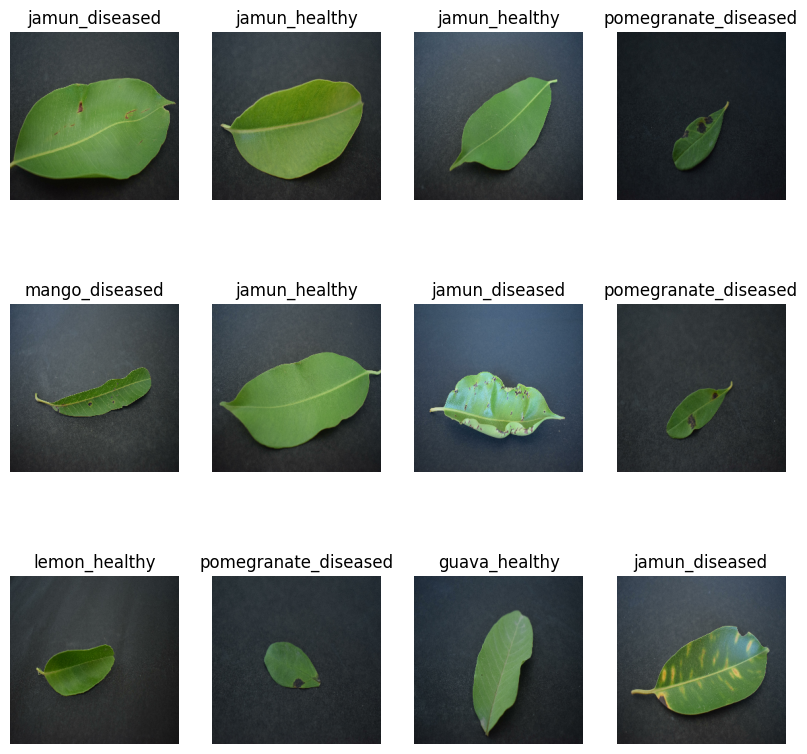

In [ ]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in train_ds.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [ ]:
#pre-processing: data augmentation
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [ ]:
#Applying data augmentation to the dataset
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

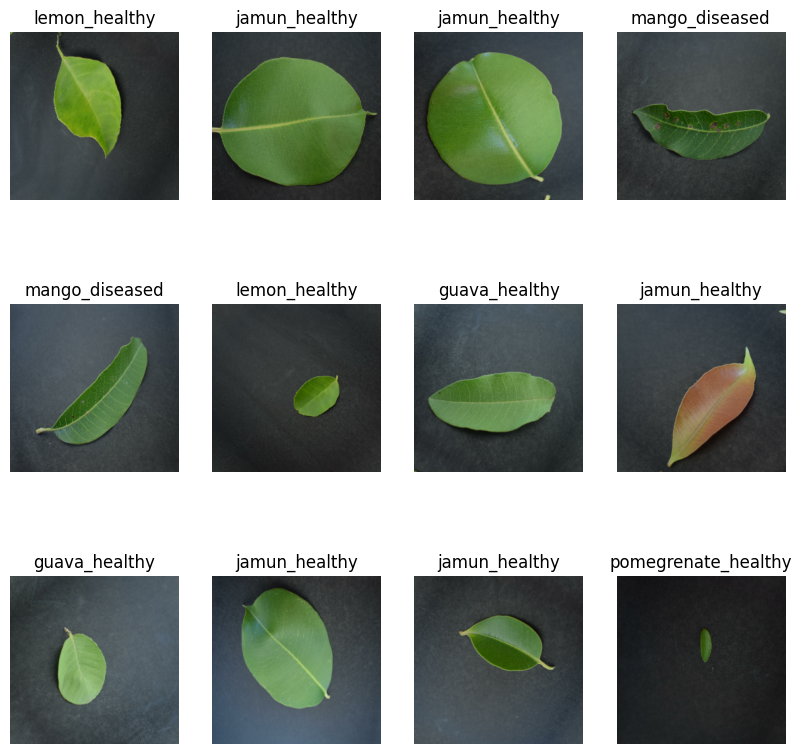

In [ ]:
#disable shuffling to see augmentation result

plt.figure(figsize=(10, 10))
for image_batch, labels_batch in train_ds.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [ ]:
#building CNN model
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
totalClasses = 10

model = models.Sequential([
    #feature extraction
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    #classification
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(totalClasses, activation='softmax'),
])

model.build(input_shape=input_shape)

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 32)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (32, 123008)             

In [ ]:
model.compile(
    optimizer=keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
#training
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS,
)

Epoch 1/30
57/57 [==============================] - 290s 5s/step - loss: 1.9077 - accuracy: 0.3268 - val_loss: 1.2472 - val_accuracy: 0.5670
Epoch 2/30
57/57 [==============================] - 127s 2s/step - loss: 1.0975 - accuracy: 0.5965 - val_loss: 1.0969 - val_accuracy: 0.5893
Epoch 3/30
57/57 [==============================] - 131s 2s/step - loss: 0.9057 - accuracy: 0.6480 - val_loss: 0.7919 - val_accuracy: 0.6830
Epoch 4/30
57/57 [==============================] - 150s 3s/step - loss: 0.7706 - accuracy: 0.7155 - val_loss: 0.7627 - val_accuracy: 0.7232
Epoch 5/30
57/57 [==============================] - 142s 2s/step - loss: 0.7384 - accuracy: 0.7314 - val_loss: 0.6356 - val_accuracy: 0.7098
Epoch 6/30
57/57 [==============================] - 128s 2s/step - loss: 0.6824 - accuracy: 0.7451 - val_loss: 0.7340 - val_accuracy: 0.6875
Epoch 7/30
57/57 [==============================] - 122s 2s/step - loss: 0.5965 - accuracy: 0.7895 - val_loss: 0.5352 - val_accuracy: 0.7500
Epoch 8/30
57

In [ ]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 142s 613ms/step - loss: 0.2092 - accuracy: 0.9258


In [ ]:
scores2 = model.evaluate(train_ds)

57/57 [==============================] - 46s 800ms/step - loss: 0.1885 - accuracy: 0.9298


In [ ]:
scores3 = model.evaluate(val_ds)

7/7 [==============================] - 1s 151ms/step - loss: 0.3325 - accuracy: 0.8884


In [ ]:
score4 = model.evaluate(dataset)

72/72 [==============================] - 34s 421ms/step - loss: 0.2842 - accuracy: 0.8953


In [ ]:
scores

[0.31214383244514465, 0.897777795791626]

In [ ]:
scores2

[0.22717326879501343, 0.9084429740905762]

In [ ]:
scores3

[0.33246177434921265, 0.8883928656578064]

In [ ]:
score4

[0.2842201590538025, 0.8952925801277161]

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

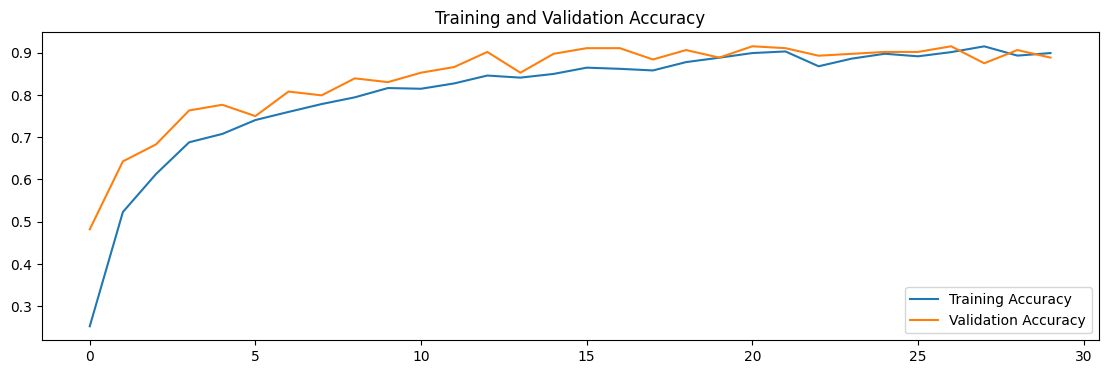

In [ ]:
plt.figure(figsize=(30, 4))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.show()

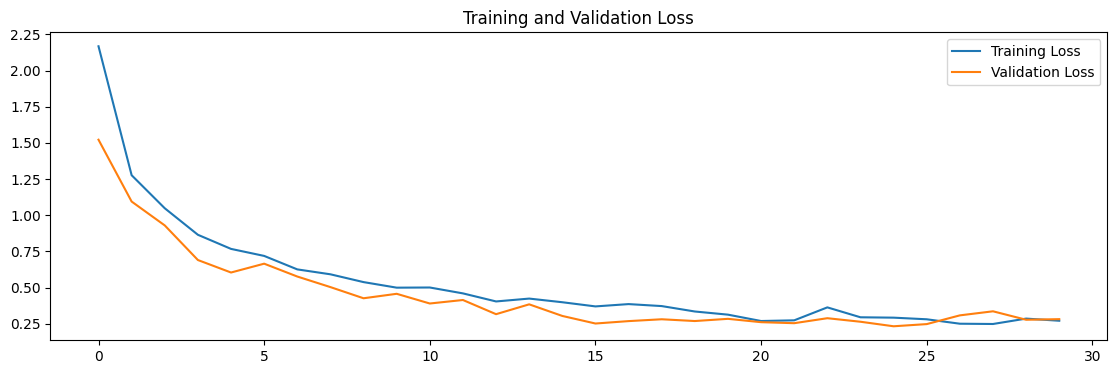

In [ ]:
plt.figure(figsize=(30, 4))
plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: mango_healthy
1/1 [==============================] - 0s 459ms/step
predicted label: mango_healthy


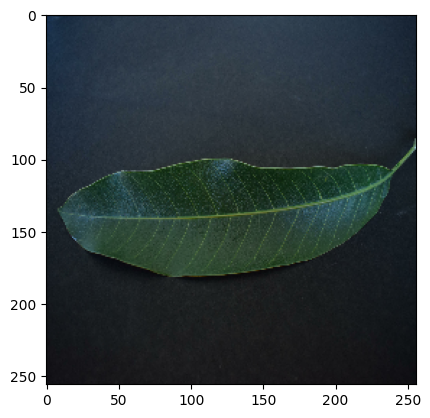

In [ ]:
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 41ms/step


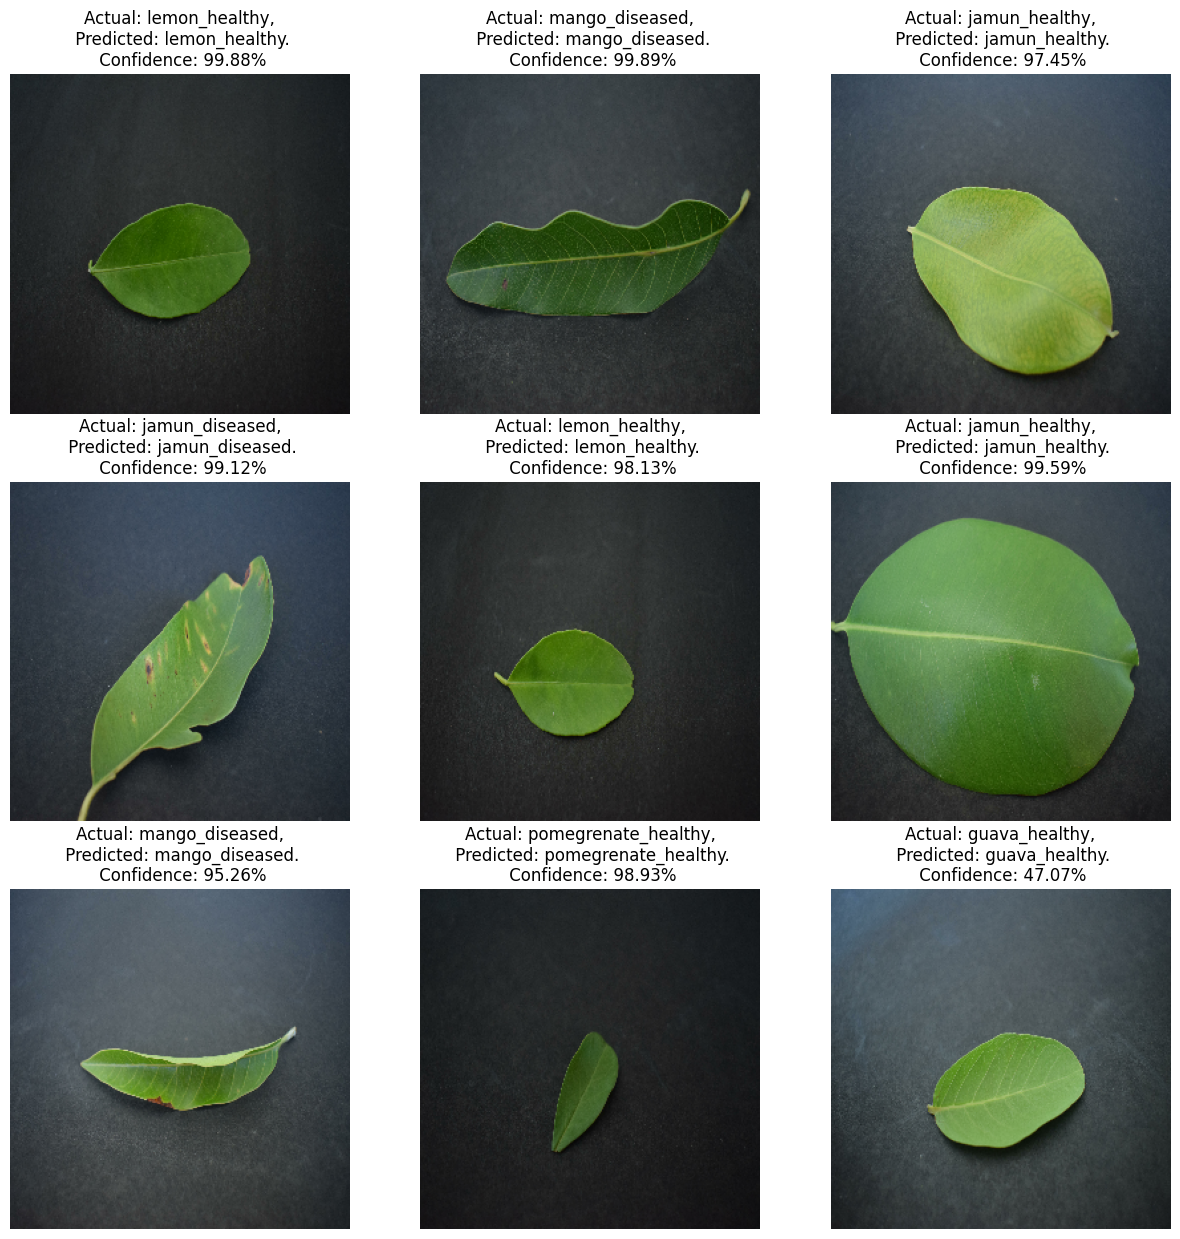

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

In [ ]:
y_pred_prob = model.predict(test_ds)

8/8 [==============================] - 27s 134ms/step


In [ ]:
#predicted probability
print(y_pred_prob)

[[1.0968069e-04 2.0839320e-01 2.2163038e-04 ... 4.8703691e-03
  7.6758319e-01 1.8656043e-02]
 [7.0059705e-12 8.2807375e-05 1.7683520e-08 ... 9.9991512e-01
  3.1256522e-07 1.0729005e-06]
 [3.1632021e-06 6.5797110e-07 7.7376467e-01 ... 2.3318048e-08
  1.5898199e-11 7.6770724e-18]
 ...
 [2.1862085e-11 5.2338978e-06 1.2925736e-07 ... 9.9974948e-01
  2.1861288e-06 6.1037140e-09]
 [3.5463920e-06 2.0244879e-05 6.0762238e-07 ... 9.7220290e-01
  1.0995040e-09 4.7312898e-10]
 [1.1333302e-09 1.8980498e-06 6.4025353e-06 ... 9.9752635e-01
  2.2538750e-05 1.7023187e-07]]


In [ ]:
y_pred_labels = np.argmax(y_pred_prob, axis=1)

In [ ]:
#predicted labels
print(y_pred_labels)

[8 7 2 9 1 6 9 7 1 5 8 2 6 6 6 0 8 1 6 2 7 2 9 3 1 3 6 6 1 1 2 1 8 6 5 4 0
 8 5 2 8 6 7 0 1 5 2 8 1 0 3 4 2 6 1 8 7 7 2 1 6 6 5 9 6 9 6 1 5 1 9 2 8 7
 3 2 9 5 8 9 2 3 0 2 3 2 1 3 6 3 1 2 1 6 2 6 3 0 1 7 6 2 7 2 8 9 2 1 3 8 1
 3 0 6 4 2 1 6 7 2 9 3 6 2 1 7 8 7 3 2 4 9 2 3 7 6 2 2 0 8 9 8 6 2 2 6 6 2
 9 0 0 6 9 2 2 7 9 3 9 0 5 3 7 6 2 2 6 2 2 8 1 3 9 7 9 0 0 2 9 3 8 5 9 1 9
 6 2 8 1 8 1 6 3 1 7 8 2 8 2 9 9 5 0 1 8 6 6 9 7 8 6 4 8 0 9 8 2 8 7 7 8 6
 7 7 7]


In [ ]:
y_true_labels = np.concatenate([y for x, y in test_ds], axis=0)

In [ ]:
#true labels
print(y_true_labels)

[9 7 2 9 1 6 9 7 1 5 9 2 6 6 6 0 9 1 6 2 7 2 9 3 1 1 6 6 1 1 0 1 8 3 5 5 0
 8 5 2 8 6 7 1 1 5 2 8 1 0 3 4 2 6 1 8 7 7 2 1 6 6 5 9 6 9 6 1 5 1 9 2 8 7
 3 2 9 5 8 9 2 3 0 2 3 2 1 3 6 3 1 2 1 6 2 6 3 0 1 7 6 2 7 2 9 9 3 1 3 8 1
 2 0 6 4 2 1 6 7 2 9 3 6 2 1 7 8 7 3 2 4 9 2 3 7 6 2 3 0 8 9 8 6 2 2 6 6 2
 9 3 1 6 9 2 2 7 9 3 9 0 5 3 7 0 2 2 6 2 2 8 1 3 9 7 9 0 0 2 9 3 8 5 9 1 9
 6 2 8 1 8 1 6 3 1 7 8 2 8 2 9 9 5 0 1 8 6 6 9 7 8 6 4 8 1 9 8 2 8 7 7 8 6
 7 7 7]


In [ ]:
cm = confusion_matrix(y_true_labels, y_pred_labels)

In [ ]:
def calculate_accuracy(confusion_matrix):
    diagonal_sum = np.trace(confusion_matrix)
    total_sum = np.sum(confusion_matrix)
    accuracy = diagonal_sum / total_sum
    return accuracy

accuracy = calculate_accuracy(cm)
print("Accuracy:", accuracy)

Accuracy: 0.9288888888888889


In [ ]:
#predictions from the model
y_pred = model.predict(test_ds)
y_pred_classes = np.argmax(y_pred, axis=1)

#true labels
y_true = np.concatenate([y for _, y in test_ds], axis=0)

#confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

#accuracy for each class
accuracy_per_class = []
for class_index in range(len(class_names)):
    TP = cm[class_index, class_index]
    TN = np.sum(np.delete(np.delete(cm, class_index, axis=0), class_index, axis=1))
    FP = np.sum(cm[:, class_index]) - TP
    FN = np.sum(cm[class_index, :]) - TP
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    accuracy_per_class.append(accuracy)

# Print
for class_index, class_name in enumerate(class_names):
    print(f"Accuracy for class '{class_name}': {accuracy_per_class[class_index]}")


8/8 [==============================] - 1s 130ms/step
Accuracy for class 'guava_diseased': 0.9733333333333334
Accuracy for class 'guava_healthy': 0.9822222222222222
Accuracy for class 'jamun_diseased': 0.9822222222222222
Accuracy for class 'jamun_healthy': 0.9733333333333334
Accuracy for class 'lemon_diseased': 0.9955555555555555
Accuracy for class 'lemon_healthy': 0.9955555555555555
Accuracy for class 'mango_diseased': 0.9911111111111112
Accuracy for class 'mango_healthy': 1.0
Accuracy for class 'pomegranate_diseased': 0.9822222222222222
Accuracy for class 'pomegrenate_healthy': 0.9822222222222222


In [ ]:
def calculate_specificity(confusion_matrix):
    true_negatives = confusion_matrix[0, 0]
    false_positives = confusion_matrix[0, 1]
    specificity = true_negatives / (true_negatives + false_positives)
    return specificity

specificity = calculate_specificity(cm)
print("Specificity:", specificity)

Specificity: 1.0


In [ ]:
#predictions from the model
y_pred = model.predict(test_ds)
y_pred_classes = np.argmax(y_pred, axis=1)

#true labels
y_true = np.concatenate([y for _, y in test_ds], axis=0)

#confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

#specificity for each class
specificity_per_class = []
for class_index in range(len(class_names)):
    TN = np.sum(np.delete(np.delete(cm, class_index, axis=0), class_index, axis=1))
    FP = np.sum(cm[:, class_index]) - cm[class_index, class_index]
    specificity = TN / (TN + FP)
    specificity_per_class.append(specificity)

# Print
for class_index, class_name in enumerate(class_names):
    print(f"Specificity for class '{class_name}': {specificity_per_class[class_index]}")


8/8 [==============================] - 1s 127ms/step
Specificity for class 'guava_diseased': 0.9811320754716981
Specificity for class 'guava_healthy': 1.0
Specificity for class 'jamun_diseased': 0.983957219251337
Specificity for class 'jamun_healthy': 0.9901960784313726
Specificity for class 'lemon_diseased': 0.995475113122172
Specificity for class 'lemon_healthy': 1.0
Specificity for class 'mango_diseased': 0.9896373056994818
Specificity for class 'mango_healthy': 1.0
Specificity for class 'pomegranate_diseased': 0.9801980198019802
Specificity for class 'pomegrenate_healthy': 1.0


In [ ]:
def calculate_sensitivity(confusion_matrix):
    true_positives = confusion_matrix[1, 1]
    false_negatives = confusion_matrix[1, 0]
    sensitivity = true_positives / (true_positives + false_negatives)
    return sensitivity

sensitivity = calculate_sensitivity(cm)
print("Sensitivity:", sensitivity)

Sensitivity: 0.9


In [ ]:
#predictions from the model
y_pred = model.predict(test_ds)
y_pred_classes = np.argmax(y_pred, axis=1)

#true labels
y_true = np.concatenate([y for _, y in test_ds], axis=0)

#confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

#sensitivity for each class
sensitivity_per_class = []
for class_index in range(len(class_names)):
    TP = cm[class_index, class_index]
    FN = np.sum(cm[class_index, :]) - TP
    P = np.sum(cm[:, class_index])
    sensitivity = TP / (TP + FN)
    sensitivity_per_class.append(sensitivity)

# Print
for class_index, class_name in enumerate(class_names):
    print(f"Sensitivity for class '{class_name}': {sensitivity_per_class[class_index]}")


8/8 [==============================] - 1s 127ms/step
Sensitivity for class 'guava_diseased': 0.8461538461538461
Sensitivity for class 'guava_healthy': 0.8709677419354839
Sensitivity for class 'jamun_diseased': 0.9736842105263158
Sensitivity for class 'jamun_healthy': 0.8095238095238095
Sensitivity for class 'lemon_diseased': 1.0
Sensitivity for class 'lemon_healthy': 0.9090909090909091
Sensitivity for class 'mango_diseased': 1.0
Sensitivity for class 'mango_healthy': 1.0
Sensitivity for class 'pomegranate_diseased': 1.0
Sensitivity for class 'pomegrenate_healthy': 0.8620689655172413


In [ ]:
def calculate_precision(confusion_matrix):
    true_positives = confusion_matrix[1, 1]
    false_positives = confusion_matrix[0, 1]
    precision = true_positives / (true_positives + false_positives)
    return precision

precision = calculate_precision(cm)
print("Precision:", precision)

Precision: 1.0


In [ ]:
#predictions from the model
y_pred = model.predict(test_ds)
y_pred_classes = np.argmax(y_pred, axis=1)

#true labels
y_true = np.concatenate([y for _, y in test_ds], axis=0)

#confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

#precision for each class
precision_per_class = []
for class_index in range(len(class_names)):
    TP = cm[class_index, class_index]
    FP = np.sum(cm[:, class_index]) - TP
    P = np.sum(cm[class_index, :])
    precision = TP / (TP + FP)
    precision_per_class.append(precision)

# Print
for class_index, class_name in enumerate(class_names):
    print(f"Precision for class '{class_name}': {precision_per_class[class_index]}")


8/8 [==============================] - 1s 129ms/step
Precision for class 'guava_diseased': 0.7333333333333333
Precision for class 'guava_healthy': 1.0
Precision for class 'jamun_diseased': 0.925
Precision for class 'jamun_healthy': 0.8947368421052632
Precision for class 'lemon_diseased': 0.8
Precision for class 'lemon_healthy': 1.0
Precision for class 'mango_diseased': 0.9411764705882353
Precision for class 'mango_healthy': 1.0
Precision for class 'pomegranate_diseased': 0.8518518518518519
Precision for class 'pomegrenate_healthy': 1.0


In [ ]:
def calculate_f1_score(confusion_matrix):
    true_positives = confusion_matrix[1, 1]
    false_positives = confusion_matrix[0, 1]
    false_negatives = confusion_matrix[1, 0]

    precision = true_positives / (true_positives + false_positives)
    recall = true_positives / (true_positives + false_negatives)

    f1_score = 2 * (precision * recall) / (precision + recall)
    return f1_score

f1_score = calculate_f1_score(cm)
print("F1 Score:", f1_score)

F1 Score: 0.9473684210526316


In [ ]:
#predictions from the model
y_pred = model.predict(test_ds)
y_pred_classes = np.argmax(y_pred, axis=1)

#true labels
y_true = np.concatenate([y for _, y in test_ds], axis=0)

#confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

#F1 score for each class
f1_score_per_class = []
for class_index in range(len(class_names)):
    TP = cm[class_index, class_index]
    FP = np.sum(cm[:, class_index]) - TP
    FN = np.sum(cm[class_index, :]) - TP
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    f1_score = 2 * (precision * recall) / (precision + recall)
    f1_score_per_class.append(f1_score)

# Print
for class_index, class_name in enumerate(class_names):
    print(f"F1 score for class '{class_name}': {f1_score_per_class[class_index]}")


8/8 [==============================] - 1s 135ms/step
F1 score for class 'guava_diseased': 0.7857142857142856
F1 score for class 'guava_healthy': 0.9310344827586207
F1 score for class 'jamun_diseased': 0.9487179487179489
F1 score for class 'jamun_healthy': 0.8500000000000001
F1 score for class 'lemon_diseased': 0.888888888888889
F1 score for class 'lemon_healthy': 0.9523809523809523
F1 score for class 'mango_diseased': 0.9696969696969697
F1 score for class 'mango_healthy': 1.0
F1 score for class 'pomegranate_diseased': 0.92
F1 score for class 'pomegrenate_healthy': 0.9259259259259259


In [ ]:
# data = tf.data.Dataset.from_tensor_slices((images, labels))
for image, labels in test_ds:
    arr = labels.numpy()
    arr_expanded = np.expand_dims(arr, axis=0)
    arr2 = np.concatenate(arr_expanded, axis = 0)
    print(arr2)

[5 7 2 0 8 5 7 4 1 8 1 6 6 6 0 9 4 1 8 2 2 1 3 5 3 9 7 6 3 5 3 3]
[3 2 3 7 0 9 1 8 1 1 2 2 1 0 6 1 9 5 6 7 1 3 2 2 7 9 5 9 9 3 9 9]
[8 9 1 7 8 6 9 2 8 7 1 5 6 6 6 3 2 2 2 3 5 0 1 5 3 0 1 9 3 1 8 8]
[5 3 2 1 8 8 3 3 6 1 2 7 0 6 2 2 1 1 4 6 3 2 3 3 0 6 7 1 3 3 5 3]
[9 0 2 2 5 7 2 3 2 4 3 3 2 4 2 6 8 8 4 3 9 2 4 9 2 4 6 8 9 9 3 2]
[2 2 2 4 6 5 5 6 6 1 2 1 1 1 6 9 5 9 6 8 1 6 8 3 3 0 0 2 2 2 0 6]
[6 1 2 3 7 6 0 6 7 1 8 9 1 9 1 2 7 5 0 0 1 6 2 9 3 1 5 6 8 3 8 3]
[3]


In [ ]:
plabel = labels.numpy()
print(plabel)

[3]


In [ ]:
predicted_probabilities = model.predict(test_ds)
print(predicted_probabilities)

8/8 [==============================] - 1s 130ms/step
[[6.8898307e-06 1.1908127e-02 7.3513645e-04 ... 2.3659992e-03
  5.5516102e-06 3.5501675e-12]
 [8.5496334e-14 1.1185771e-11 3.5484984e-10 ... 9.9999487e-01
  6.1729783e-15 8.9845530e-13]
 [1.3627467e-04 3.8923935e-03 6.2524283e-01 ... 2.4873841e-06
  5.8421901e-10 5.3864802e-11]
 ...
 [1.1526009e-05 4.2928813e-04 4.5154218e-05 ... 2.9311056e-04
  9.9778467e-01 5.6668714e-04]
 [2.2112286e-05 1.1723476e-04 7.6759271e-02 ... 2.7582233e-04
  2.5695124e-08 2.6183564e-09]
 [2.3043726e-04 3.5189551e-03 1.3410174e-02 ... 8.3206961e-04
  6.5307895e-06 1.2627146e-08]]


In [ ]:
predicted_labels = np.argmax(predicted_probabilities, axis=1)
print(predicted_labels)

[5 7 2 6 8 5 7 4 1 9 1 6 6 6 0 9 5 1 8 2 3 1 3 5 2 9 7 6 3 5 3 3 3 2 3 7 0
 9 1 8 1 1 2 6 1 2 6 1 9 5 6 7 1 2 2 2 7 9 5 9 9 3 9 9 8 9 1 7 8 6 9 2 8 7
 1 5 6 6 6 2 2 2 2 3 5 0 1 5 3 0 1 9 3 1 8 8 5 3 2 7 8 8 3 2 6 1 0 7 3 6 3
 2 1 1 5 6 3 1 2 3 2 6 7 1 2 3 5 3 9 0 2 2 5 7 2 3 2 2 3 3 2 5 2 6 8 8 4 3
 9 2 7 9 2 5 6 8 9 9 1 3 2 2 2 4 6 5 5 6 6 1 2 1 1 1 6 9 5 9 6 8 1 6 8 3 3
 0 0 2 3 2 2 6 6 1 2 2 7 6 0 6 7 1 8 9 1 9 1 2 7 5 0 0 1 6 2 9 2 1 5 6 8 3
 8 3 3]
